In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import shelve

from tqdm.auto import trange, tqdm
from IPython.core.display import display, HTML


from rknot import Sim, Chart
from rknot.sim import recycler
from rknot.dots.matrix import ML, MLNB
from rknot.helpers import contacts_of_init_inf, \
    find_n_sec, get_results, pickload, picksave
from rknot.notebook import md, curvehist, ktrhist, rohist, \
    curve_table, meanvar_table
from rknot.nb import funcs as nbf
from rknot.dots.fhutch import tmr

plt.style.use('rknot_nb')

## Sizing ##

Appropriate sizing of a simulation environment is more art than science but we can use several tools in the **RKnot** package and the scientific literature to approximate appropriate attributes and initial conditions.

Our main guides for appropriate sizing:

1. Actual $R_0$ should be close to target $R_0$
2. Contact rate should follow a gamma distribution with parameters found in the [Hutch model](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf).
3. $R_0$ distribution should replicate the [Endo distribution](https://wellcomeopenresearch.org/articles/5-67#ref-12).

Our main tools for adjusting contact rates and $R_0$ distribution are:

+ Density
+ [Mover functions](concepts.ipynb#Mover-Functions)
+ [Events](concepts.ipynb#Events)
+ [VBoxes](concepts.ipynb#VBoxes)

___
### Importance of Distributions ###

Both the distribution of contacts *and* individual $R_0$ are important considerations when formulating a realistic model of viral spread.

In terms of contacts, both frequency and timing are important. All else equal, an infected individual will cause more secondary infections if they have more contacts. BUT an infected individual contacting the same number of people at two different times is likely to cause more secondary infections at the time of greater viral load.

The SIR model makes many simplifying assumptions that fail to replicate real world spread. In particular, SIR is characterized by:

* Uniform, average contact rates
* Constant transmission risk

These two assumptions result in normally distributed contact rates among all individuals in an environment and normally distributed individual $R_0$.

[Endo et al](https://wellcomeopenresearch.org/articles/5-67#ref-12), however, have suggested that 70%+ of all sars-cov-2 infections *lead to $\underline{\text{NO}}$ secondary infections.* And that the vast majority of secondary infections are due to a small minority of super-spreader carriers.

To account for this, the [Hutch team](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf) modelled contacts with a gamma distribution, which (relative to the Gaussian) favors many more instances of 0 contacts, but also allows for a very long tail of large contacts depending on the dispersion parameter.

___
### Constant Contact Rate and Transmission Risk ###

To replicate the Hutch approach in **RKnot**, we must first understand contact and transmission dynamics in more generalized scensarios.

We will use the `looper` helper function to run 1,000 interations of simulations for two environments:

1. Equal Mover scenario with `density=1`.
2. Equal Mover with `density=5`

```python
from rknot.helpers import looper

params = dict(density=1, R0=2.5, infdur=14, days=14, sterile=True,)
group = dict(name='all', n=10000, n_inf=1, ifr=0, mover='equal',)
contacts_1, nsecs_1, _, __ = looper(n=1000, groups=group, **params)

params['density'] = 5
contacts_5, nsecs_5, _, __ = looper(n=1000, groups=group, **params)
```

#### Daily Contact Distribution ####
The daily contact mean and variance are found simply as `contacts_1.mean()`, `contacts_1.var()`, etc. For each environment, the mean, variance, and density are about equal.

Seen as per table below:

In [7]:
R0 = 2.5
file = 'tests/data/transmit'

with shelve.open(file, writeback=True) as db:
    equal_scen = db[f'SIR equal 10000n dens1']['2020-11-15']

    contacts = equal_scen['contacts']
    nsecs = equal_scen['R0']
    res1 = equal_scen['results']
    meanstr = round(contacts.mean(), 4)
    varstr = round(contacts.var(), 4)

    testdens = 5
    densdct = db[f'SIR equal 10000n dens{testdens}']['2020-11-15']

    contacts2 = densdct['contacts']
    nsecs2 = densdct['R0']
    res2 = densdct['results']
    meanstr2 = round(contacts2.mean(), 4)
    varstr2 = round(contacts2.var(), 4)

    comps = [contacts, contacts2]
    header = r'Density, $\rho$'
    comp_vals = [1, testdens]

In [12]:
table = r'''
    <table>
        <thead>
            <tr>
                <th class="results-table">Density, $\rho$</th>
                <th class="results-table">$\overline{{k}}$</th>
                <th class="results-table">$\sigma^2$</th>
            </tr>
        </thead>
    '''
table += f'''
        <tbody>
            <tr>
                <td class="results-table">1</td>
                <td class="results-table">{comps[0].mean():.4f}</td>
                <td class="results-table">{comps[0].var():.4f}</td>
            </tr>
            <tr>
                <td class="results-table">5</td>
                <td class="results-table">{comps[1].mean():.4f}</td>
                <td class="results-table">{comps[1].var():.4f}</td>
            </tr>
        </tbody>
    </table>
'''

display(HTML((table)))

"Density, $\rho$",$\overline{{k}}$,$\sigma^2$
1,0.9973,0.9731
5,4.9436,4.9607


We can also see below that daily contacts are normally distributed in *both* environments (technically, [binomially distributed as discussed here](theory.ipynb#Expected-Contact-Rate)).

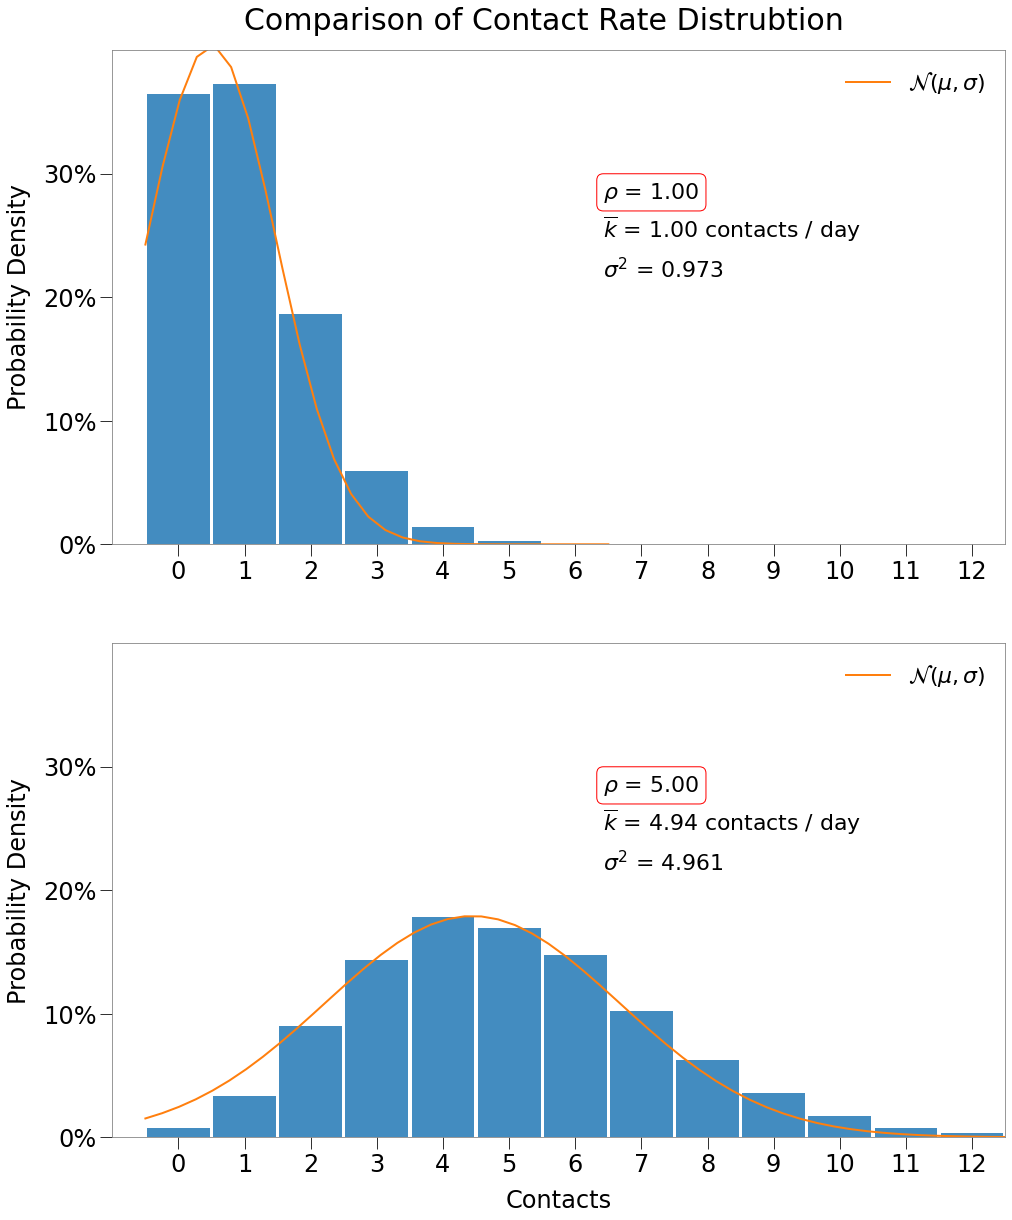

In [24]:
fig, (ax1, ax2)= plt.subplots(2,1, figsize=(16,20))
with np.errstate(divide='ignore', invalid='ignore'):
    title = 'Comparison of Contact Rate Distrubtion'
    ktrhist(contacts, overlay='norm', ax=ax1, values={r'$\rho$': 1}, xlim=(0,13))
    ktrhist(
        contacts2, title=title, title_y=.91, overlay='norm', 
        ax=ax2, values={r'$\rho$': testdens}, xlim=(0,13), ylim=(0,0.4)
    )
    
ax1.set_xlabel('')
plt.show()

In [18]:
from rknot.notebook import make_note
from IPython.core.display import display, HTML

title = 'SIR auto-adjusts for density'
additional = 'When R0 and infdur are provided, <b>RKnot</b> will '
additional += 'automatically scale the transmission risk such that '
additional += 'the environment will produce the desired R0, regardless '
additional += 'of the density. We can see this in the next comparison.'

display(HTML(make_note(title, additional)))

#### Curve Details ####

In the table below, we show the results of the simulations across the two environments.

In [25]:
hits1 = res1[:, 1]
hits2 = res2[:, 1]

means1 = np.concatenate((res1.mean(axis=0), np.array([(np.sum(hits1 == 0) / hits1.shape[0])])))
means2 = np.concatenate((res2.mean(axis=0), np.array([(np.sum(hits2 == 0) / hits2.shape[0])])))

means1 = means1[[0,1,2,-2,-1]]
means2 = means2[[0,1,2,-2,-1]]

headers = [r'$\rho$ = 1', r'$\rho$ = 5'] 

args = [means1, means2]
    
display(HTML(curve_table(headers, args, style='results-nofat')))

,$\rho$ = 1,$\rho$ = 5
Peak,40.1%,38.6%
HIT,61.6%,59.5%
Total,82.4%,79.5%
Days to Peak,66,64


Both environments do a decent job of meeting the expected HIT. With $R_0$ of 2.5 (and assuming SIR conditions), HIT is generally understood to be $1 - 1/R_0 = 1 - 1 / 2.5 =$ 60%

That said, this is in part due to the fact that ~10% of all simulations ended with *no secondary infections*, so most simulations ended with between 65% and 75% HIT as per below:

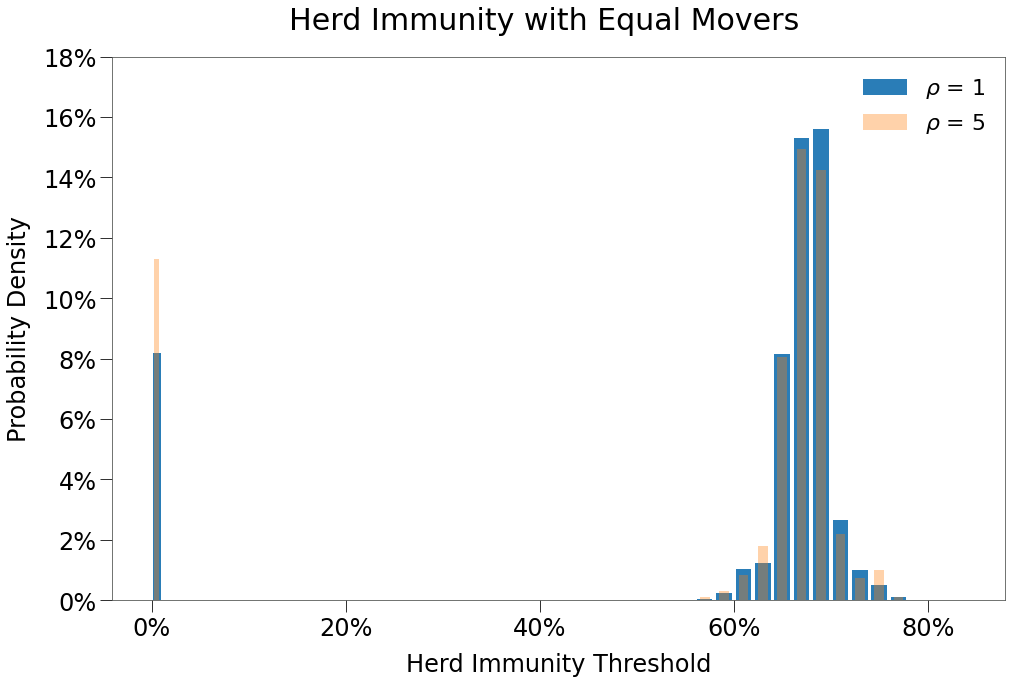

In [29]:
labels = [r'$\rho$ = 1', r'$\rho$'+ f' = {testdens}']
title = 'Herd Immunity with Equal Movers'
curvehist([hits1, hits2], labels, widths=[.8,.5], title=title)

#### Secondary Infection Distribution ####

Now, we compare the $R_0$ generated in each simulation of the two environments. Each chart below shows the actual number of secondary infections generated in each of 1,000 simulations with two different distributions overlayed.

+ a Binomial distribution deterimined as follows:

$$
\begin{equation}
B(n,p) = B(\text{infdur} * \overline{k}, \frac{R_0 / \text{infdur}}{\overline{k}})
\\where: n = \overline{c} = \text{infdur} * \overline{k}
\\ p = R_0 / \overline{k} / \text{infdur}
\\ \overline{c} = \text{average total contacts}
\\ \overline{k} = \text{average daily contact rate}
\end{equation}
$$

$\frac{R_0}{\textit{infdur}}$ number of infections occuring during each day and $\frac{R_0 / \textit{infdur}}{\overline{k}}$ infections occuring per contact.
    
+ the Endo distribution determined as follows:

$$
\begin{equation}
\textit{Endo}(R_0, \omega)
\\\textit{where: }\omega \textit{ is the overdispersion parameter}
\end{equation}
$$

The Endo model is fairly complex so readers are encouraged to research it [here](https://wellcomeopenresearch.org/articles/5-67#ref-12). The paper determined an optimized value of $\omega$ of **0.1** sars-cov-2, which will be used for our purposes.

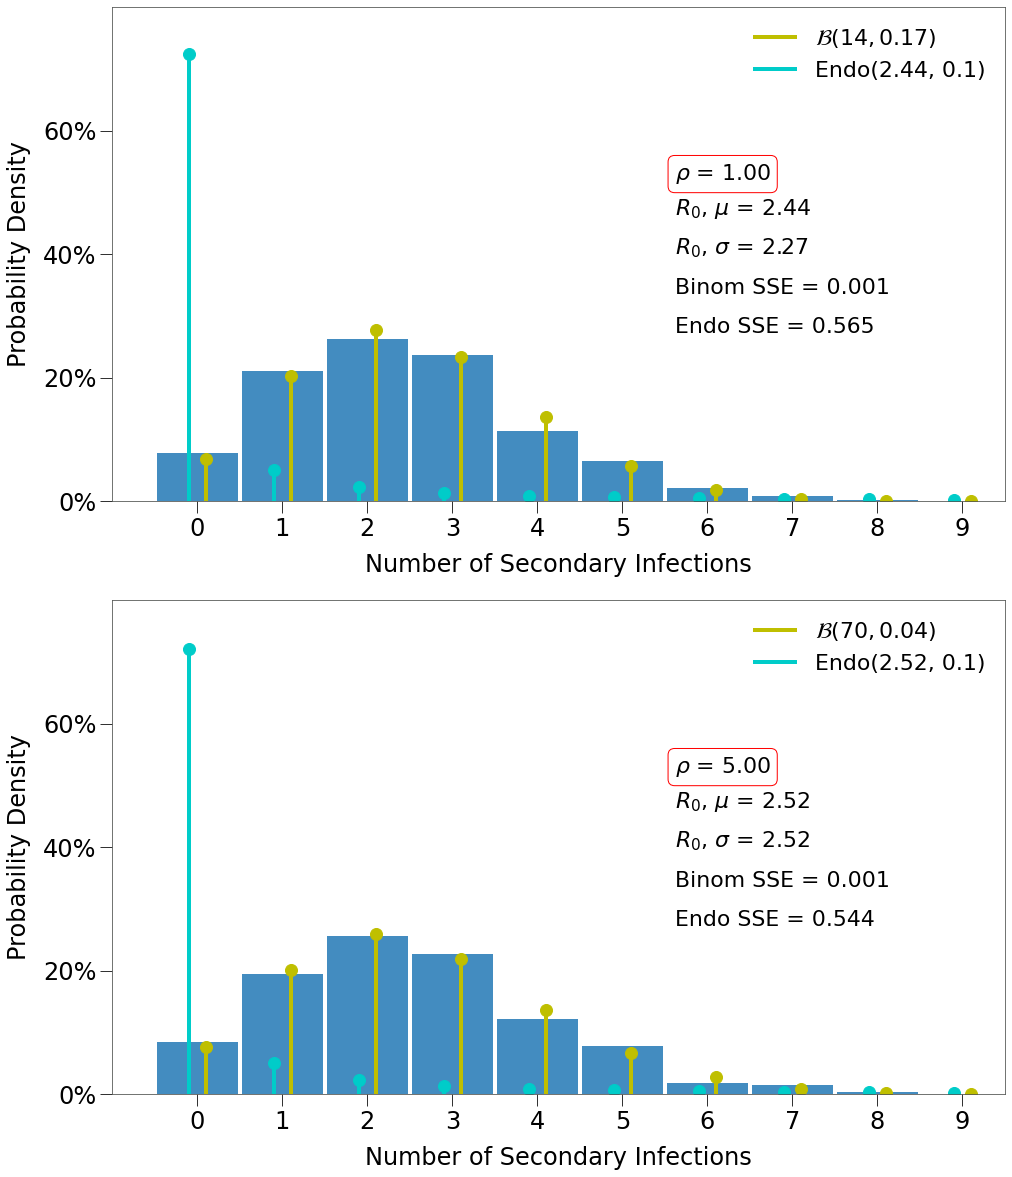

In [30]:
fig, (ax1, ax2)= plt.subplots(2,1, figsize=(16,20))

title = r'Comparison of $R_0$ Distribution'
with np.errstate(divide='ignore', invalid='ignore'):
    rohist(
        nsecs, R0=2.5, compare=['binom', 'endo'], ax=ax1,
        density=1, values={r'$\rho$': 1}, title=title, title_y=.95,
    )
    rohist(nsecs2, R0=2.5, compare=['binom', 'endo'], ax=ax2,
        density=5, values={r'$\rho$': 5}
    )

We can see both environments do a good job of generating ~2.5 secondary infections, on average. 

We also see that both have $R_0$ distributions that fit the binomial distribution, not the Endo.

___
### Movement Changes ###

We have seen the impact of density on the properties of the spread. Now we investigate the impact of movement patterns.

#### Local Bias ####

`local` patterns restrict the movement of a dot to only the nearest available locations. This is achieved using a geometric distribution with the `p` parameter governing the amount of restriction. The larger the `p`, the greater the restriction.

This is illustrated below:

In [2]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import shelve

from tqdm.auto import trange, tqdm

from rknot import Sim, Chart

from rknot import Sim
from rknot.parallel import Server
from rknot.dots.matrix import ML, MLNB
from rknot.helpers import contacts_of_init_inf, find_n_sec, get_results
from rknot.notebook import md, ktrhist, rohist, meanvar_table, curve_table
from rknot.nb.funcs import find_all_contacts, clear_cache
from rknot.dots.fhutch import tmr

from matplotlib import markers as mpl_markers
from matplotlib.lines import Line2D

plt.style.use('rknot_nb')

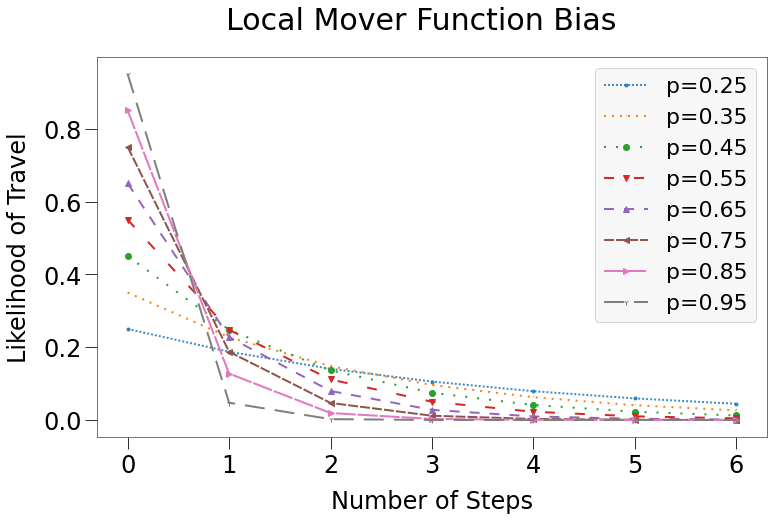

In [3]:
markers = list(Line2D.markers.keys())

fig, ax = plt.subplots(1,1, figsize=(12,7))

x = np.arange(1, 8)
p = np.linspace(0.05, 0.95, 19)
linestyles = [
    (0, (1, 1)),
    (0, (1, 3)),
    (0, (1, 5)),
    (0, (5, 10)),
    (0, (5, 5)),
    (0, (5, 1)),
    (0, (10, 1)),
    (0, (10, 5)),
]

for i, j in enumerate(range(4, len(p), 2)):
    ax.plot(x-1, st.geom.pmf(x, p[j]), linestyle=linestyles[i], lw=2,
        label=f'p={p[j]:.2}', marker=markers[i]
    )

ax.set_ylabel('Likelihood of Travel')
ax.set_xlabel('Number of Steps')
ax.legend(loc='best')
plt.suptitle('Local Mover Function Bias')
plt.savefig('imgs/sizing_local_bias')

There are [several pre-defined mover functions](concepts.ipynb#Mover-Functions), which can be utilized by providing a string or integer value to the `mover` attribute of a `Group`. The `local` mover function, for instance, utilizes a geometric distribution with p-value of 0.6.

The `mover` attribute *also* accepts a float value, which is then provided as the specified p-value to a geometric distribution. 

With this feature, we can generate simulations across a range of p-values.

Then, we can use the helper function `find_all_contacts` to generate a 2d array of the number of the contacts on each tick for every dot in each sim. Then multiply the contacts the transmission risk curve to get the *expected* $R_0$ for every dot in the sim *as though they were infected initially*.

Repeat this for each `p-value`. Here, we cannot use `looper`, because the properties of each sim will change slightly, but we can use the `recycler` decorator to simplify the loop and pass existing `server` and `worker` actors if they are available.

```python
from rknot import Sim
from rknot.sim import recycler
from rknot.helpers import find_all_contacts

params = dict(density=.75, R0=2.5, infdur=14, days=14, sterile=True, n_workers=1)
group = dict(name='all', n=10000, n_inf=1, ifr=0,)

p = np.concatenate((p, np.linspace(0.96, .99, 4)))

dotlogs = np.zeros(shape=(p.shape[0], params['days']+1, group['n'], len(ML)), dtype=np.int32)
all_contacts = np.zeros(shape=(p.shape[0], group['n'], params['days']), dtype=np.int32)
tmrs = np.zeros(shape=(p.shape[0], params['infdur']))

sim_cycler = recycler(p.shape[0])
for i in trange(p.shape[0]):
    group['mover'] = p[i]
    sim = sim_cycler(groups=group, pbar=False,  **params)
    sim.run(dotlog=True, pbar=False)
    dotlogs[i] = sim.dotlog
    all_contacts[i] = nbf.find_all_contacts(sim.dotlog, MLNB)
    tmrs[i] = sim.tmrs
        
contact_means = all_contacts.sum(axis=2).mean(axis=1) / params['days']
eR0s = np.zeros(all_contacts.shape[0])
for i in range(eR0s.shape[0]):
    eR0_by_dot = tmrs[i] * all_contacts[i]
    eR0_mu = eR0_by_dot.sum(axis=1).mean()
    eR0s[i] = eR0_mu
```

In [20]:
params = dict(
    density=.75,
    R0=2.5,
    infdur=14,
    days=14,
    sterile=True,
    n_workers=1
)
group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
)
p = np.linspace(0.05, 0.95, 19)
p = np.concatenate((p, np.linspace(0.96, .99, 4)))

SAVE = False
if SAVE:
    dotlogs = np.zeros(shape=(p.shape[0], params['days']+1, group['n'], len(ML)), dtype=np.int32)
    all_contacts = np.zeros(shape=(p.shape[0], group['n'], params['days']), dtype=np.int32)
    tmrs = np.zeros(shape=(p.shape[0], params['infdur']))

    sim_cycler = recycler(p.shape[0])
    for i in trange(p.shape[0]):
        group['mover'] = p[i]
        sim = sim_cycler(groups=group, pbar=False,  **params)
        sim.run(dotlog=True, pbar=False)
        dotlogs[i] = sim.dotlog
        all_contacts[i] = nbf.find_all_contacts(sim.dotlog, MLNB)
        tmrs[i] = sim.tmrs

from datetime import datetime as dt, timedelta as td
from rknot.helpers import ShelfHelp
file = 'tests/data/sizing_pval'
key = 'local p-value v R0'

if SAVE:
    with shelve.open(file, writeback=True) as db:
         db[key] = [dotlogs, all_contacts, tmrs]
else:
    with shelve.open(file, writeback=True) as db:
        dotlogs, all_contacts, tmrs = db[key]
        
contact_means = all_contacts.sum(axis=2).mean(axis=1) / params['days']
eR0s = np.zeros(all_contacts.shape[0])
for i in range(eR0s.shape[0]):
    eR0_by_dot = tmrs[i] * all_contacts[i]
    eR0_mu = eR0_by_dot.sum(axis=1).mean()
    eR0s[i] = eR0_mu

We can then chart $E(R_0)$ against `p-value` to see the impact of restricting movement on spread.

Further, we show the change in mean contacts against `p-value` (which is a similar curve) and fit that curve to a 5-degree polynomial. This will be helpful in building [Complex Environments](#Complex-Environments).

We can also easily accomodate densities less than one by simply multiplying the polyfit parameters by the density.

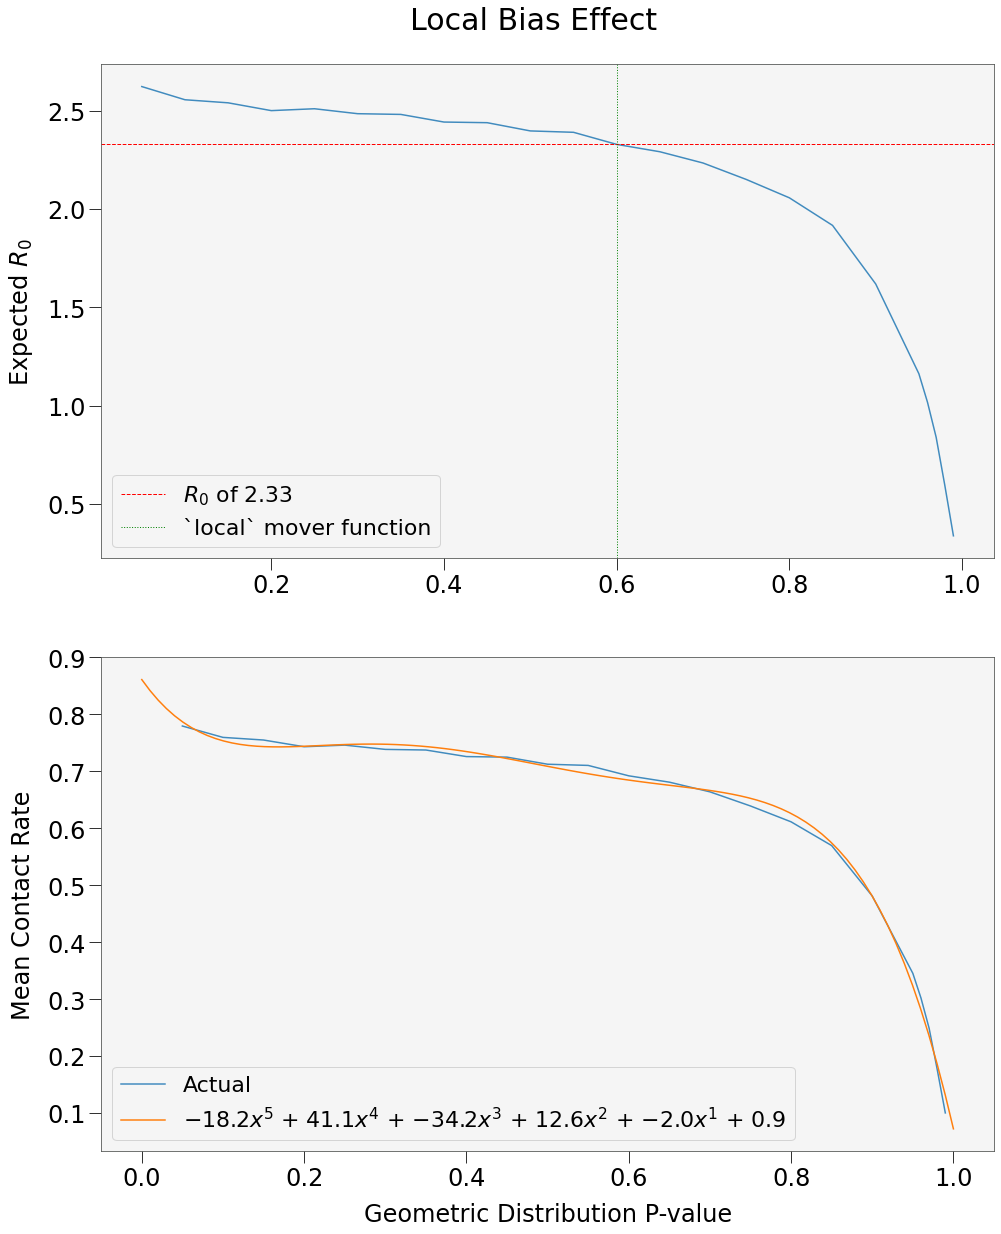

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,20))

ax1.plot(p, eR0s)
ax1.axhline(2.33, ls='--', c='r', label=r'$R_0$ of 2.33', lw=1)
ax1.axvline(.6, ls='dotted', c='g', label='`local` mover function', lw=1)

ax2.plot(p, contact_means, label='Actual')
z = np.polyfit(p, contact_means, 5)
kp_curve = np.poly1d(z)
x = np.linspace(0,1,100)
ax2.plot(x, kp_curve(x), label=' + '.join(['${}$'.format(p) + ('$x^{}$'.format(len(z) - deg - 1) if deg != len(z) - 1 else '') for deg, p in enumerate(np.around(z, 1))]))

ax1.set_ylabel(r'Expected $R_0$')
ax1.legend(loc='lower left')

ax2.set_ylabel('Mean Contact Rate')
ax2.legend(loc='lower left')
ax2.set_xlabel('Geometric Distribution P-value')
plt.suptitle(r'Local Bias Effect', y=.92)
plt.show()

In [22]:
import shelve
from datetime import datetime as dt, timedelta as td
file = 'tests/data/sizing_ktr_polyfit'
date = dt.now().strftime('%Y-%m-%d')

if False:
    with shelve.open(file, writeback=True) as db:
        db[date] = z

We see that $R_0$ has an inverse relationship to restricted movement (i.e. spread increases as populations become more well-mixed). This, of course, makes sense and is a fundamental premise of viral spread theory.

$\underline{\text{However}}$ what cannot be overlooked is how closely $R_0$ in a *moderately* restricted environment resembles a completely well-mixed environment. And yet we know that the `local` [mover function (with p-value of 0.6) results in a very different long-term spread curve](sir.ipynb#2.-Local).

Further, each p-value results in normally-distributed contacts. We show this for a handful of p-values below.

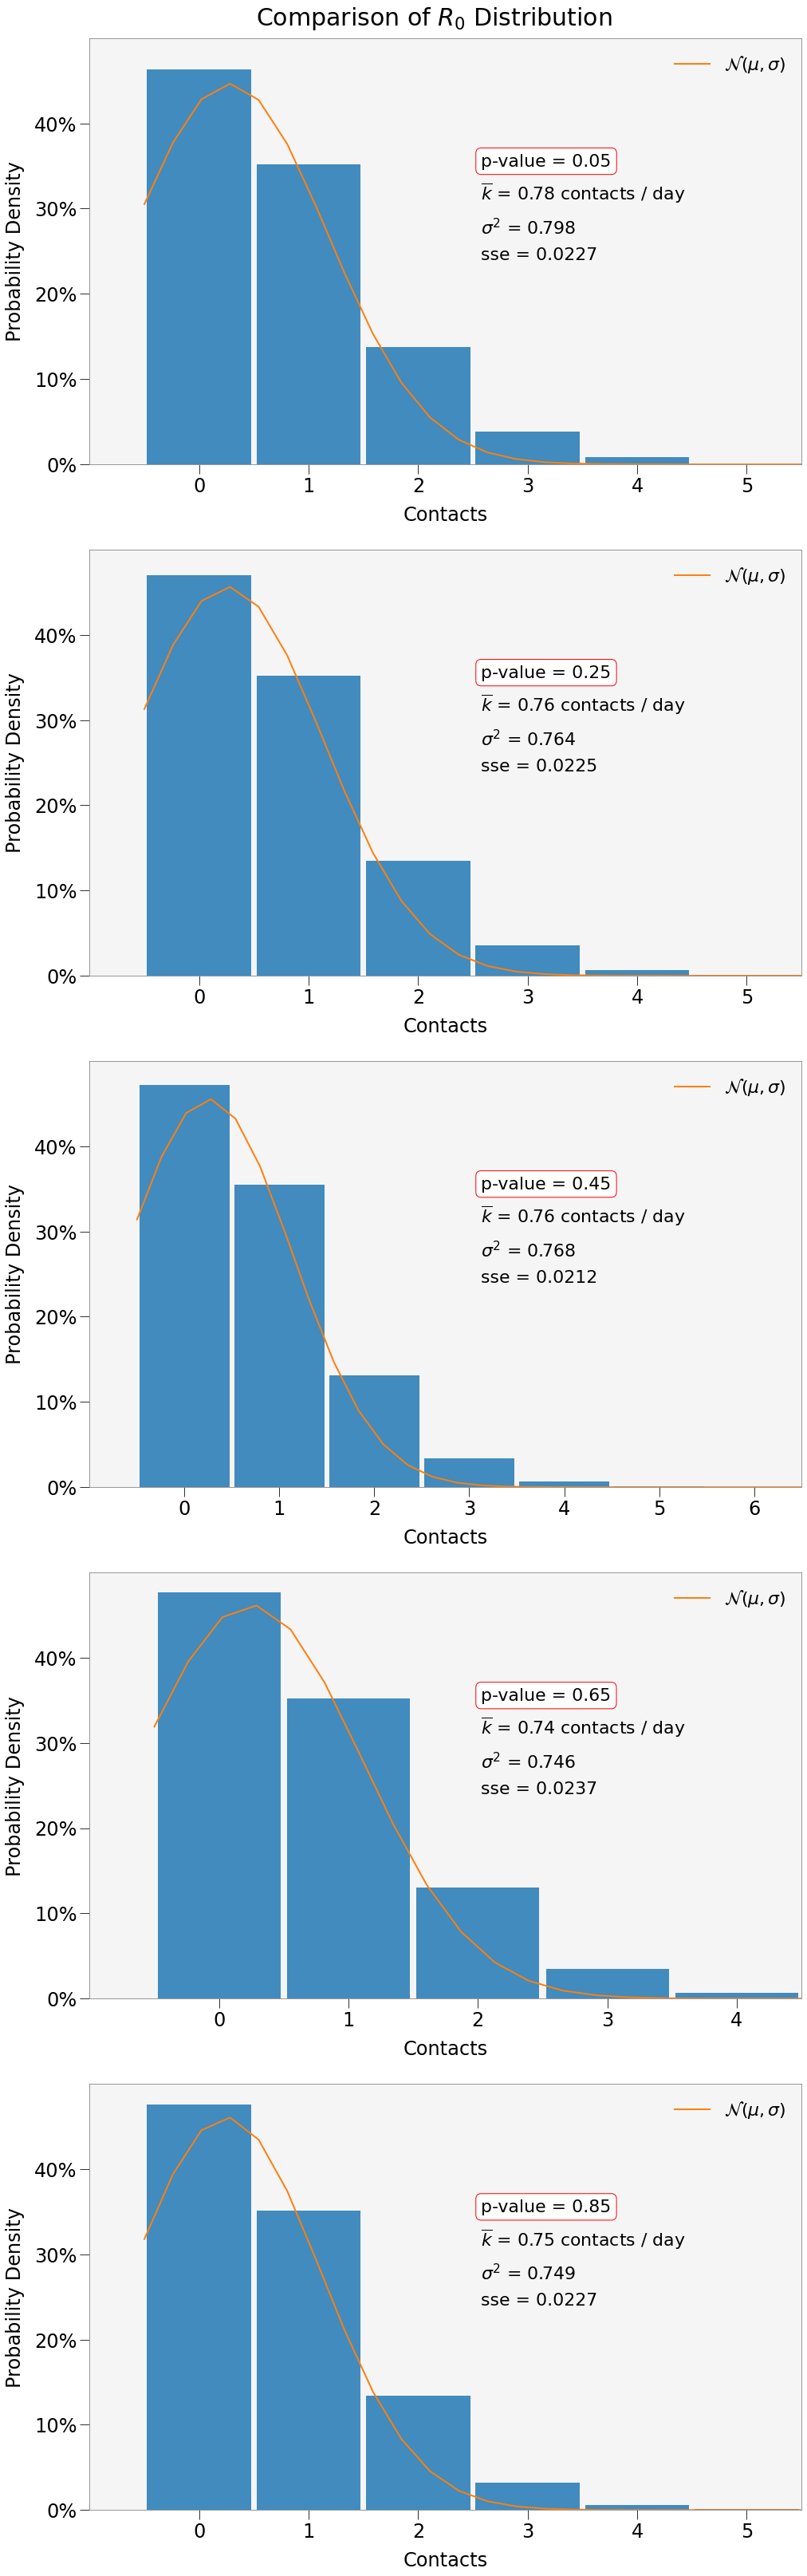

In [23]:
fig, axs = plt.subplots(p.shape[0] // 4, 1, figsize=(16, 10*p.shape[0] // 4))
axs = axs.ravel()
with np.errstate(divide='ignore', invalid='ignore'):
    for i in range(axs.size):
        ktrhist(
            all_contacts[i], ax=axs[i], overlay='norm', fit=True, values={'p-value': p[i*4]}
        )        
    plt.suptitle(title, y=.89)
plt.show()

#### Interplay of Movement and Density ####
We can also run each p-value against a range of densities.

```python
params = dict(
    R0=2.5,
    infdur=14,
    days=14,
    sterile=True,
    pbar=False,
    pbar_leave=False,
    reset_env=True,
)
group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
)
densities = np.array([.5, .75, 1, 2.5, 5])

dotlogs = np.zeros(shape=(
        p.shape[0], densities.shape[0], params['days']+1, group['n'], len(ML)
    ), dtype=np.int32
)
all_contacts = np.zeros(shape=(
        p.shape[0], densities.shape[0], group['n'], params['days']
    ), dtype=np.int32
)
tmrs = np.zeros(shape=(densities.shape[0], params['infdur']))

n_iters = p.shape[0]*densities.shape[0]
pbar = tqdm(total=n_iters)
sim_cycler = recycler(n_iters)
for i in range(p.shape[0]):
    group['mover'] = p[i]
    for j in range(densities.shape[0]):
        sim = sim_cycler(groups=group, density=densities[j], **params)
        sim.run(dotlog=True, pbar=False)

        dotlogs[i, j] = sim.dotlog
        all_contacts[i, j] = find_all_contacts(sim.dotlog, MLNB)
        tmrs[j] = sim.tmrs

        pbar.update(1)
```

In [44]:
import numpy as np

from rknot.helpers import pickload, picksave

params = dict(
    R0=2.5,
    infdur=14,
    days=14,
    sterile=True,
    pbar=False,
    pbar_leave=False,
    reset_env=True,
)
group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
)
p = np.linspace(0.05, 0.95, 19)
p = np.concatenate((p, np.linspace(0.96, .99, 4)))
densities = np.array([.5, .75, 1, 2.5, 5])

SAVE = False
if SAVE:
    dotlogs = np.zeros(shape=(
            p.shape[0], densities.shape[0], params['days']+1, group['n'], len(ML)
        ), dtype=np.int32
    )
    all_contacts = np.zeros(shape=(
            p.shape[0], densities.shape[0], group['n'], params['days']
        ), dtype=np.int32
    )
    tmrs = np.zeros(shape=(densities.shape[0], params['infdur']))
    
    n_iters = p.shape[0]*densities.shape[0]
    pbar = tqdm(total=n_iters)
    sim_cycler = recycler(n_iters)
    for i in range(p.shape[0]):
        group['mover'] = p[i]
        
        for j in range(densities.shape[0]):
            sim = sim_cycler(groups=group, density=densities[j], **params)
            sim.run(dotlog=True, pbar=False)

            dotlogs[i, j] = sim.dotlog
            all_contacts[i, j] = find_all_contacts(sim.dotlog, MLNB)
            tmrs[j] = sim.tmrs

            pbar.update(1)
            
from datetime import datetime as dt, timedelta as td

file = 'tests/data/pick_sizing'
key = 'local p-value v density'

if SAVE:
    vals = pickload(file)
    vals[key] = [dotlogs, all_contacts, tmrs]
    picksave(file, vals)
else:
    vals = pickload(file)
    dotlogs, all_contacts, tmrs = vals[key]
    
eR0s = np.zeros(shape=(all_contacts.shape[0], all_contacts.shape[1]))
for i in range(eR0s.shape[0]):
    for j in range(eR0s.shape[1]):
        eR0_by_dot = tmrs[j] * all_contacts[i, j]
        eR0_mu = eR0_by_dot.sum(axis=1).mean()
        eR0s[i, j] = eR0_mu

Then find the expected $R_0$ for each combination:

```python
eR0s = np.zeros(shape=(all_contacts.shape[0], all_contacts.shape[1]))
for i in range(eR0s.shape[0]):
    for j in range(eR0s.shape[1]):
        eR0_by_dot = tmrs[j] * all_contacts[i, j]
        eR0_mu = eR0_by_dot.sum(axis=1).mean()
        eR0s[i, j] = eR0_mu
```

And below we show $R_0$, contact $\mu$, and contact variance for a subset of the `p-value`/`density` combinations.

In [45]:
from rknot.notebook import md

headers = [r'$\rho$' + f' = {d}' for d in densities]
table = r'| ' + ''.join([f' | | {h} |  ' for h in headers]) + ' |'
table += ' \n'
table += '|:-------------:'*(len(headers)*3+1)
table += ' \n'
table += '| p-value ' + r'| $R_0$ | $\overline{k}$ | $\sigma^2$ '*(len(headers)+1)

for i in range(0, all_contacts.shape[0], 3):
    if (eR0s[i] != 0).all():
        table += '\n'
        table += f'| {p[i]:.2f}'
        row = []
        for j in range(all_contacts.shape[1]):
            seg = f'| {eR0s[i, j]:.2f}'
            seg += f'| {all_contacts[i, j].mean():.2f}'
            seg += f'| {all_contacts[i, j].var():.2f}'
            row.append(seg)
        table += ''.join(row)

md(table)

|  | | $\rho$ = 0.5 |   | | $\rho$ = 0.75 |   | | $\rho$ = 1.0 |   | | $\rho$ = 2.5 |   | | $\rho$ = 5.0 |   | 
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------: 
| p-value | $R_0$ | $\overline{k}$ | $\sigma^2$ | $R_0$ | $\overline{k}$ | $\sigma^2$ | $R_0$ | $\overline{k}$ | $\sigma^2$ | $R_0$ | $\overline{k}$ | $\sigma^2$ | $R_0$ | $\overline{k}$ | $\sigma^2$ | $R_0$ | $\overline{k}$ | $\sigma^2$ 
| 0.05| 2.60| 0.52| 0.52| 2.61| 0.78| 0.80| 2.60| 1.04| 1.08| 2.54| 2.48| 2.55| 2.52| 4.98| 5.12
| 0.20| 2.51| 0.50| 0.50| 2.52| 0.75| 0.75| 2.51| 1.00| 1.00| 2.55| 2.50| 2.60| 2.57| 5.09| 5.56
| 0.35| 2.45| 0.49| 0.49| 2.48| 0.74| 0.73| 2.48| 0.99| 1.01| 2.52| 2.46| 2.46| 2.53| 5.00| 5.20
| 0.50| 2.41| 0.48| 0.48| 2.41| 0.72| 0.70| 2.43| 0.97| 0.96| 2.50| 2.44| 2.41| 2.51| 4.96| 4.99
| 0.65| 2.30| 0.46| 0.45| 2.32| 0.69| 0.67| 2.29| 0.92| 0.88| 2.50| 2.44| 2.46| 2.51| 4.96| 5.06
| 0.80| 2.04| 0.41| 0.40| 2.05| 0.61| 0.58| 2.03| 0.81| 0.75| 2.54| 2.48| 2.58| 2.50| 4.94| 4.95
| 0.95| 1.17| 0.23| 0.22| 1.14| 0.34| 0.33| 1.17| 0.47| 0.43| 2.50| 2.44| 2.45| 2.48| 4.90| 4.66
| 0.98| 0.64| 0.13| 0.12| 0.60| 0.18| 0.17| 0.61| 0.25| 0.23| 2.49| 2.43| 2.40| 2.47| 4.89| 4.74

The table above has some interesting properties:

1. As expected, mean contacts, $\overline{k}$, increase with density.
2. Also, for densities of 1 or less, $\overline{k}$ decrease with p-value.
3. Also, for densities of 1 or less, $R_0$ decreases with density.

HOWEVER, when density > 1, all of the values remain almost constant for each density regardless of p-value. When a grid is overloaded with dots, by definition the same number of dots are expected at each location regardless of the movement pattern (on average).

#### Location Clustering ####
We should also mention the phenomena of dot clustering. We can determine how many different locations are occupied by at least one dot at each tick as follows:

In [26]:
unq_locs = np.zeros(shape=dotlogs.shape[:3])
for i in range(dotlogs.shape[0]):
    for j in range(dotlogs.shape[1]):
        for k in range(dotlogs.shape[2]):
            unq_locs[i,j,k] = np.unique(dotlogs[i,j,k,:,ML['loc_id']]).shape[0]

In the chart below, we can see that each sim with density < 1, starts with dots occupying 10,000 unique locations (so each dot gets its own location), but over time dots cluster to a smaller number of locations.

The clustering appears asymptotic to a long-term value. That value appears to be inversely related to the density (so lower density means more locations and less clustering). And the speed at which that value is reached is related to the p-value.

For sims with density > 1, there is no clustering.

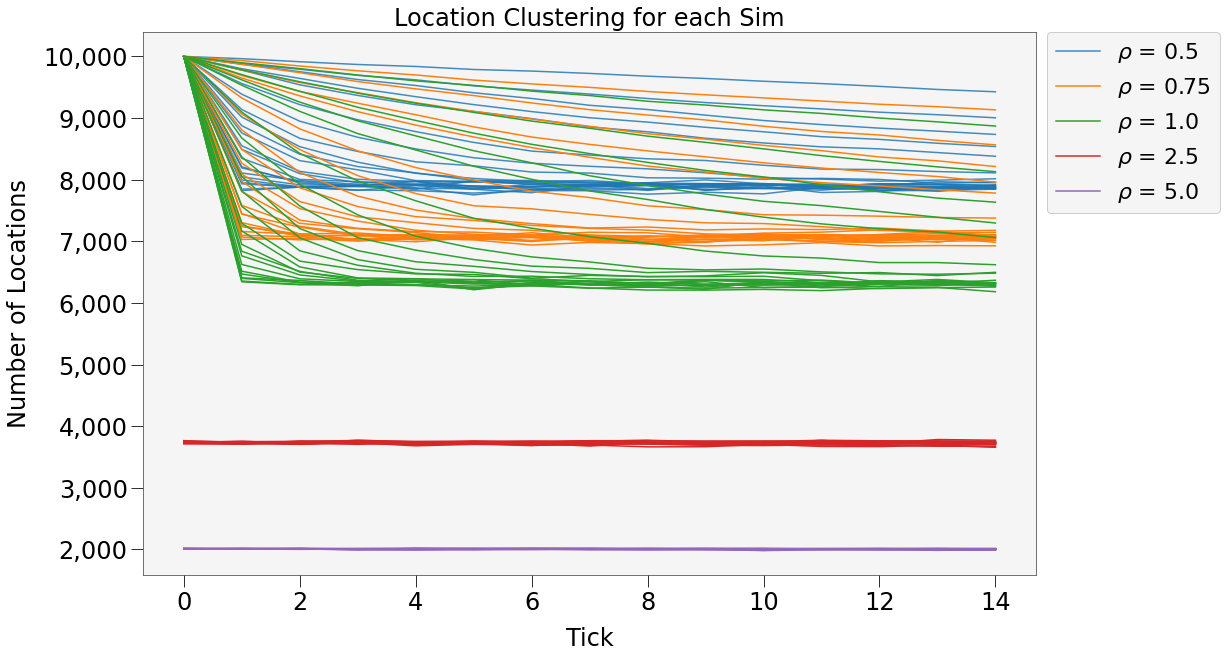

In [27]:
fig, ax = plt.subplots(figsize=(16,10))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(dotlogs.shape[0]):
    for j in range(dotlogs.shape[1]):
        label = label=r'$\rho$' + f' = {densities[j]}' if i == 0 else None
        ax.plot(unq_locs[i,j], c=colors[j], label=label)
        
ax.legend(loc='upper left', framealpha=1,  bbox_to_anchor=(1, 1.02))
ax.set_title('Location Clustering for each Sim')
ax.set_ylabel('Number of Locations')
ax.set_xlabel('Tick')

from matplotlib import ticker as mtick
@mtick.FuncFormatter
def yax_fmt(x, pos):
    return f'{x:,.0f}'
ax.yaxis.set_major_formatter(yax_fmt)

plt.show()

Below we more clearly see the relationship between p-value and speed of clustering:

1. For density of 0.5:
    + p-value is inversely related to clustering speed. i.e. movement patterns with higher p-values cluster slower
    
2. For density of 5:
    + there is no clustering and number of unique locations varies randomly in a tight range.

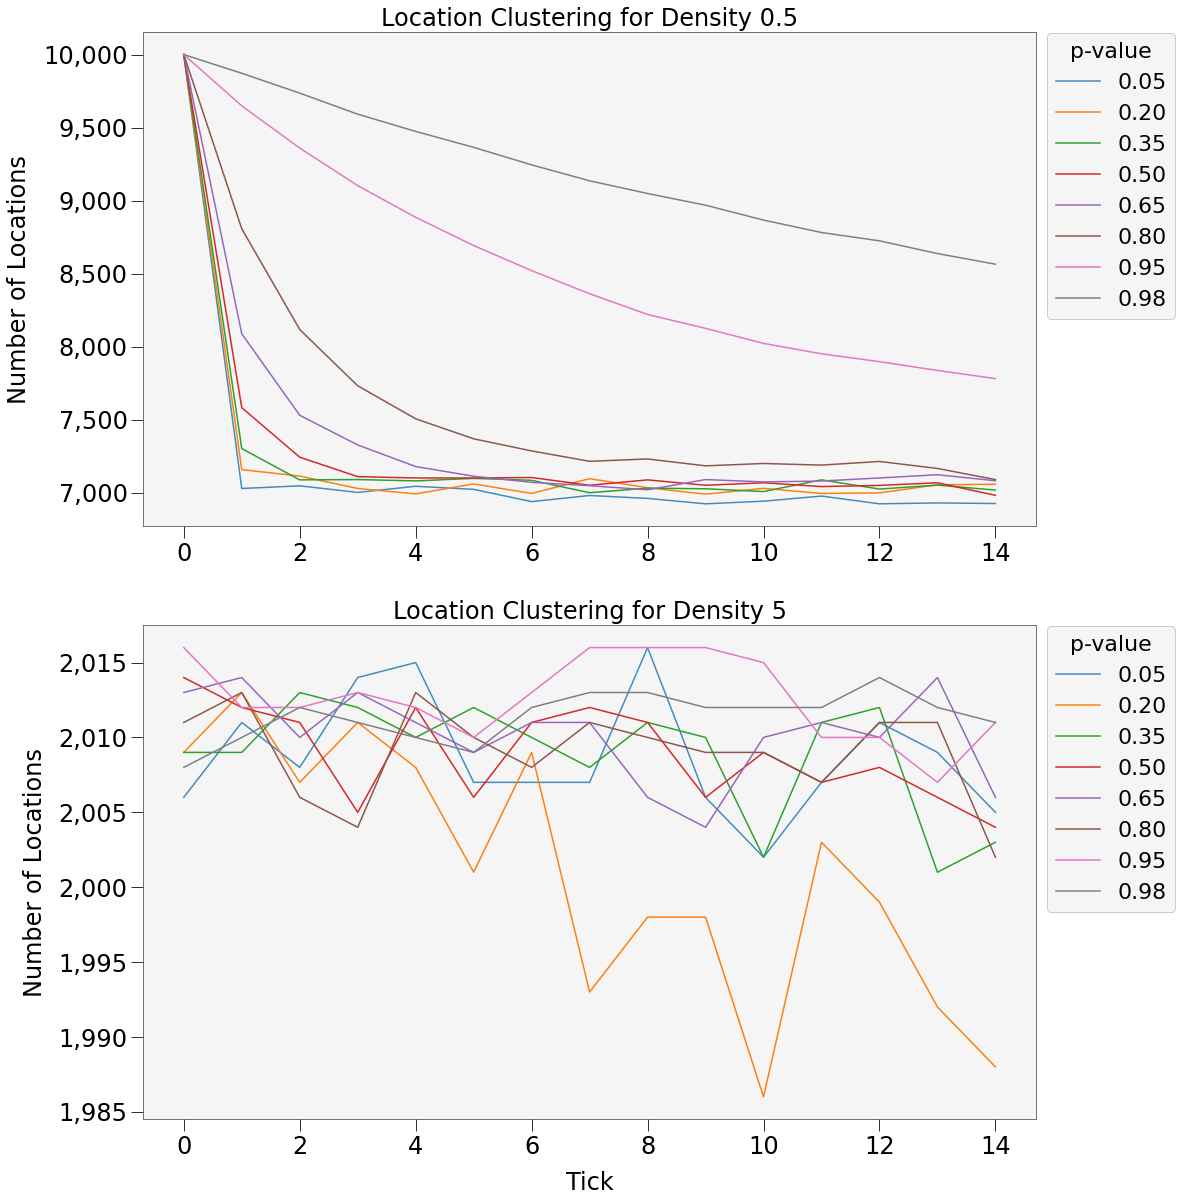

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,20))
for i in range(0, dotlogs.shape[0], 3):
    ax1.plot(unq_locs[i,1], label=f'{p[i]:.2f}')
        
ax1.legend(title='p-value', loc='upper left', framealpha=1,  bbox_to_anchor=(1, 1.02))
ax1.set_title('Location Clustering for Density 0.5')
ax1.set_ylabel('Number of Locations')

for i in range(0, dotlogs.shape[0], 3):
    ax2.plot(unq_locs[i,4], label=f'{p[i]:.2f}')
        
ax2.legend(title='p-value', loc='upper left', framealpha=1,  bbox_to_anchor=(1, 1.02))
ax2.set_title('Location Clustering for Density 5')
ax2.set_ylabel('Number of Locations')
ax2.set_xlabel('Tick')

ax1.yaxis.set_major_formatter(yax_fmt)
ax2.yaxis.set_major_formatter(yax_fmt)

plt.show()

#### $R_0$ Distribution ####
For $R_0$ distribution, we must loop through a large number of simulations. We will focus only on p-values [.25, .65, .95] and densities [.5, 1].

Again, we utilize the `looper` function.

```python
from rknot.helpers import looper

params = dict(
    R0=2.5,
    infdur=14,
    days=14,
)
group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
)

p = np.array([.25, .65, .95])
d = np.array([.5, 1])
n = 1000

nsecs = np.zeros(shape=(3, 2, n, params['days']))
pbar = tqdm(total=p.shape[0]*d.shape[0])
for i in range(p.shape[0]):
    group['mover'] = p[i]
    for j in range(d.shape[0]):
        params['density'] = d[j]
        _, loop_nsecs, _ = looper(n=n, groups=group, **params)
        
        nsecs[i, j] = loop_nsecs

        pbar.update(1)
```

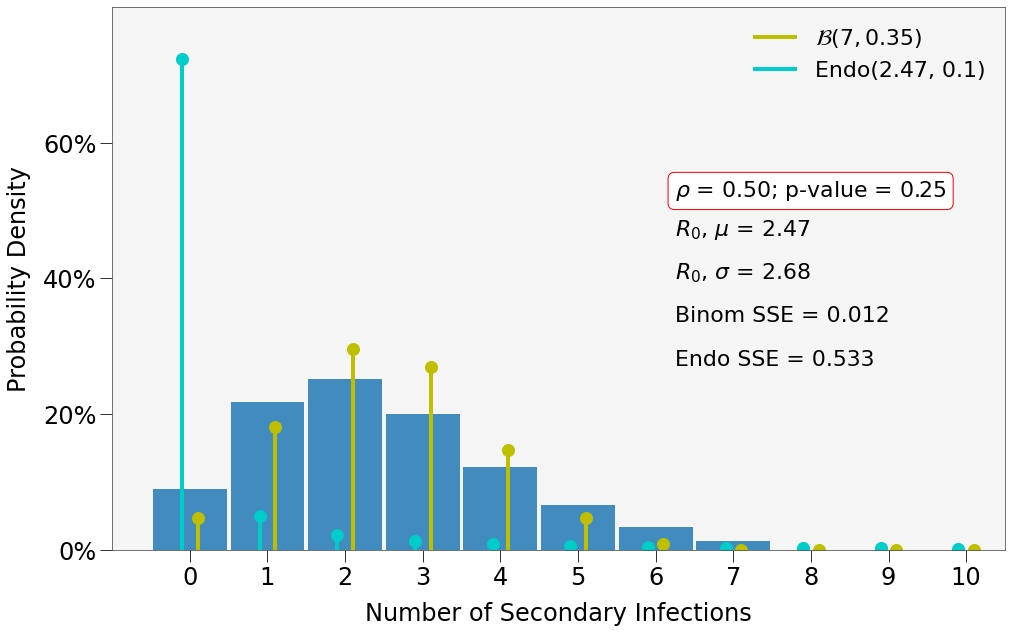

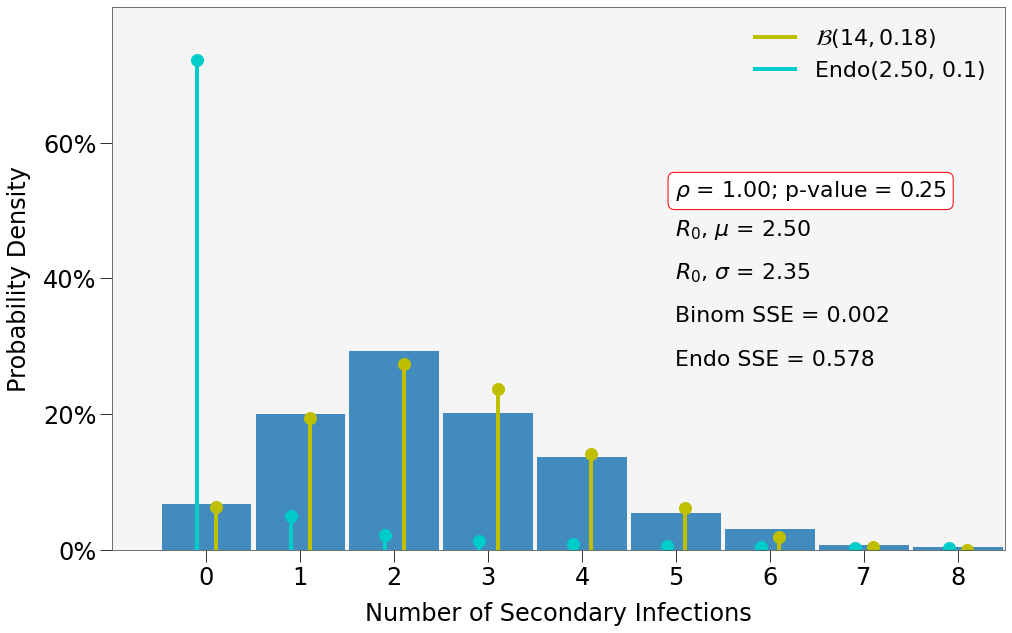

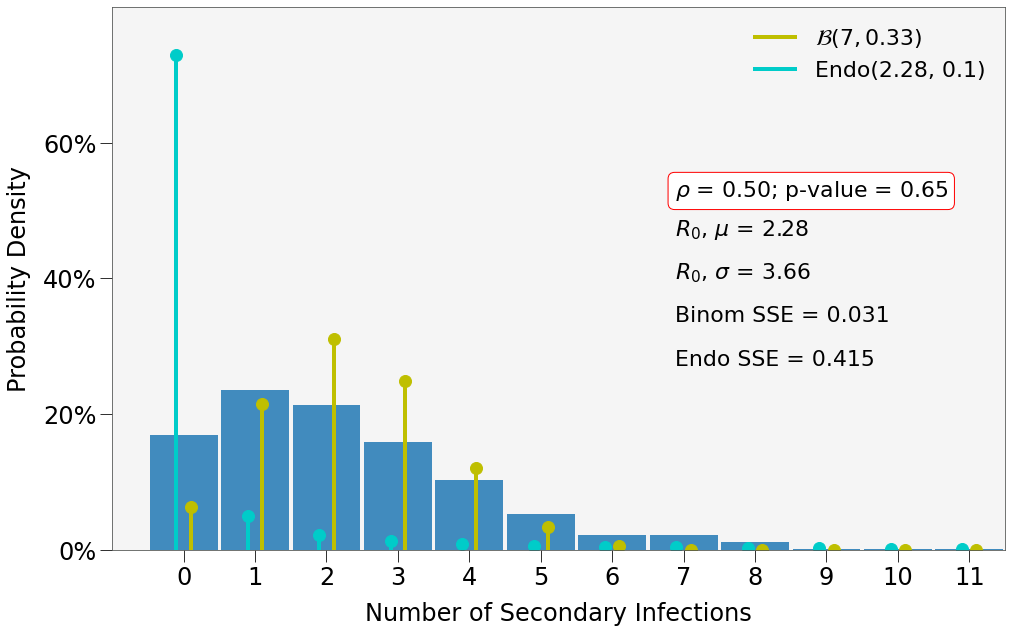

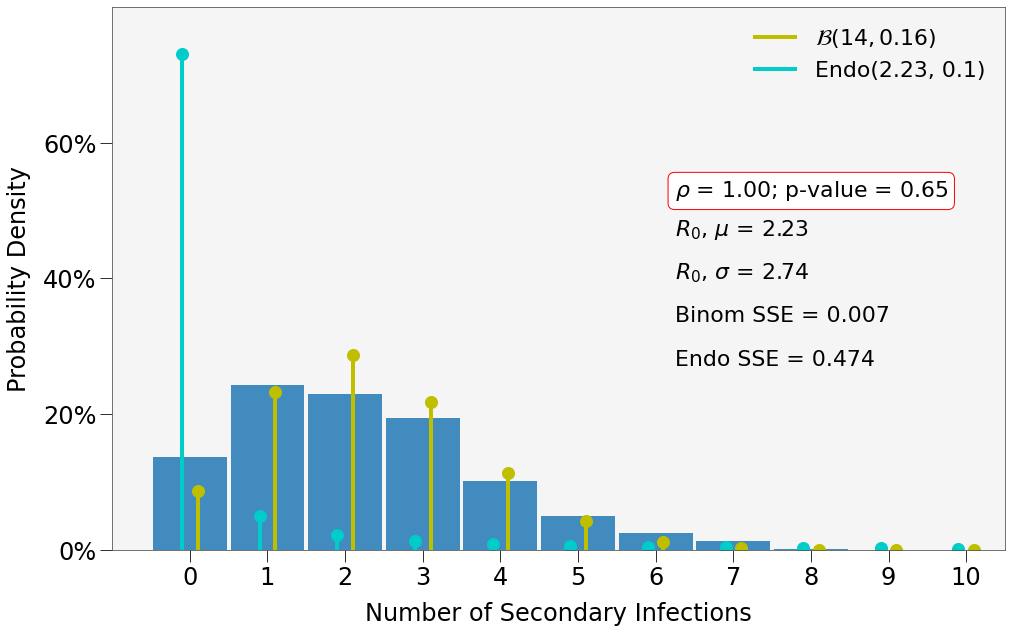

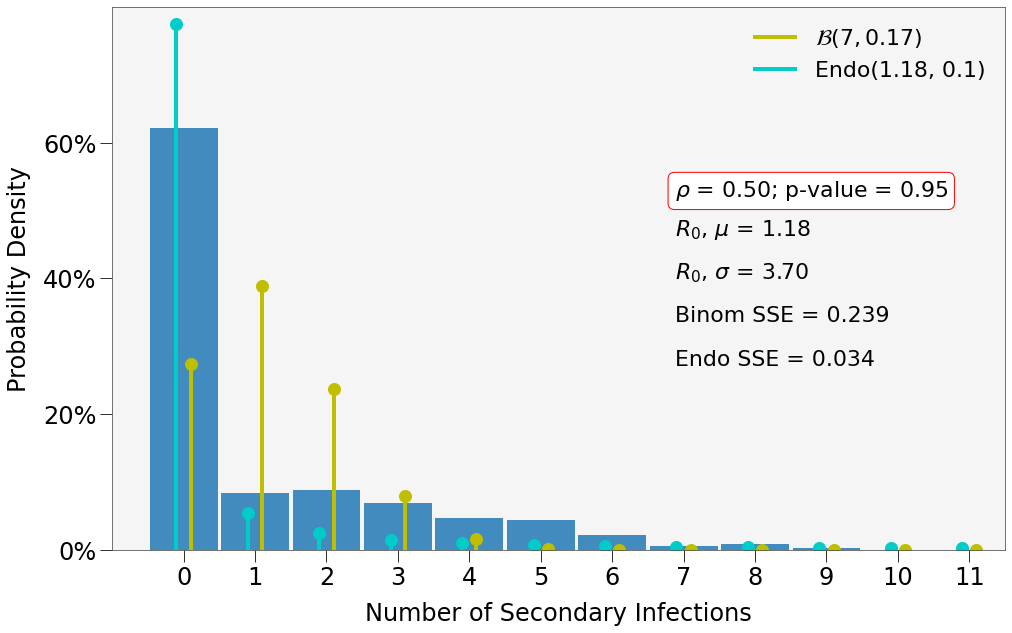

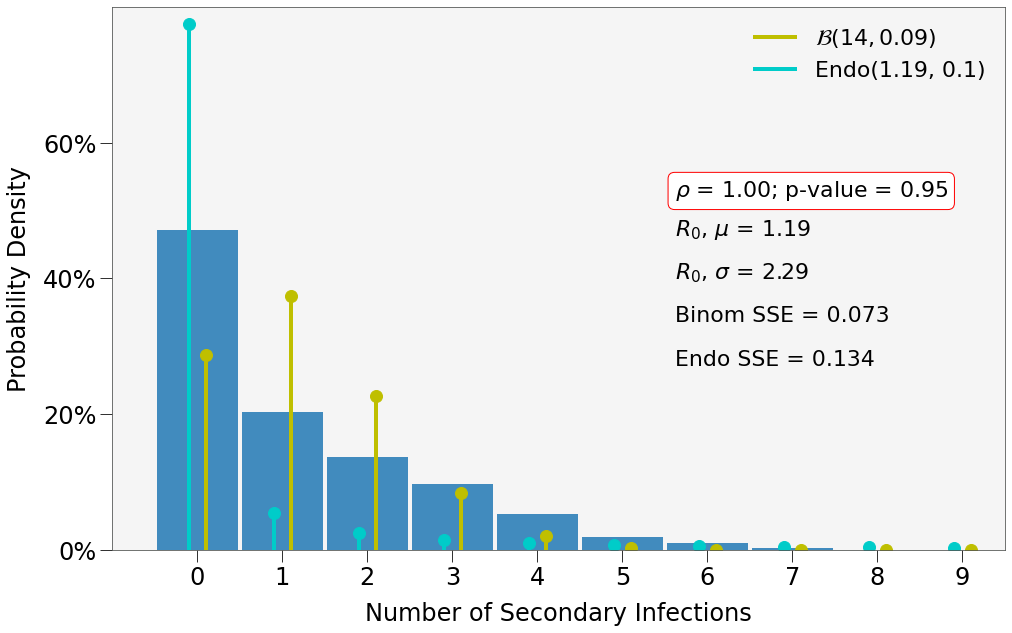

In [29]:
import shelve

from rknot.helpers import looper
from rknot.notebook import rohist

params = dict(
    R0=2.5,
    infdur=14,
    days=14,
)
group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
)

p = np.array([.25, .65, .95])
d = np.array([.5, 1])
n = 1000

SAVE = False
if False:
    nsecs = np.zeros(shape=(3, 2, n, params['days']))
    pbar = tqdm(total=p.shape[0]*d.shape[0])
    for i in range(p.shape[0]):
        group['mover'] = p[i]
        for j in range(d.shape[0]):
            params['density'] = d[j]
            _, loop_nsecs, _ = looper(n=n, groups=group, **params)

            nsecs[i, j] = loop_nsecs

            pbar.update(1)

from datetime import datetime as dt
file = 'tests/data/sizing_a'

date = '2020-12-05'
key = 'local p-value v density 1000iters'

with shelve.open(file, writeback=True) as db:
    if key not in db:
        db[key] = {}
    if date not in db[key]:
        db[key][date] = {}
    if False:
        date = dt.now().strftime('%Y-%m-%d')
        db[key][date]['nsecs'] = nsecs

    nsecs = db[key][date]['nsecs']

with np.errstate(divide='ignore', invalid='ignore'):
    for i in range(p.shape[0]):
        for j in range(d.shape[0]):
            rohist(
                nsecs[i,j], 
                R0=eR0s[i,j], density=d[j], values={r'$\rho$': d[j], 'p-value': p[i]}, compare=['binom', 'endo']
            )

Here we have a few findings:

1) There is one decent fit for the Endo model, which comes at the lowest density and the highest p-value.

2) The closest fit to the Binomial distribution comes at the highest `density=1` and the lowest p-value.

___
### Complex Environments ###

We can use our findings to structure more complex environments that more appropriately mock real world interactions.

Here, we will incorporate a dynamic transmission curve with $R_0$ dispersion that fits the [Endo model](https://wellcomeopenresearch.org/articles/5-67#ref-12).

$\underline{\text{Hutch}}$

As noted previously, with respect to sars-cov-2, the [Hutch model](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf) uses a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) to govern real world interactions as per below:

$$
\begin{equation}
c_t\;\approx\;\Gamma(\alpha, \theta)\;\approx\;\Gamma(\frac{\overline{k}}{\theta}, \theta)
\\\alpha \textit{ is the shape parameter, }
\\\mu = \overline{k}, \textit{or the average daily contact rate }
\\\theta\textit{ is the dispersion parameter}
\end{equation}
$$

The scaling parameters are related to mean and variance as follows:

$$
\begin{equation}
\\\overline{k} = \alpha\theta
\\\sigma^2 = \alpha\theta^2
\end{equation}
$$

The Hutch model combines this approach to contact distributions with a [model for dynamic viral load](theory.ipynb#Dynamic-Transmission-Risk) to estimate contact level parameters for viral transmission.

They detail two sets of parameters for two $R_0$ outcomes.

$\underline{R_0 = 1.8}$

+ mean $R_0$ of 1.8
+ 4 mean contacts per day, $\overline{k}$
+ 40 dispersion, $\theta$
+ $\lambda$ of 10**7 (a parameter influencing the relative infectiousness of an infected subjected)

$\underline{R_0 = 2.8}$

+ mean $R_0$ of 2.8
+ 20 mean contacts per day, $\overline{k}$
+ 30 dispersion, $\theta$
+ $\lambda$ of 10**7.5

The parameter best fit for both outcomes was determined on a number of external inputs including adherence to the findings of the Endo model that >70%+ primary infections caused no secondary infections.

In [19]:
from rknot.notebook import make_warning
from IPython.core.display import display, HTML

title = 'Limitation'
body = 'Currently, **RKnot** cannot replicate $R_0$ of 2.8 according '
body += r'to the above parameters as it cannot generate $\overline{k}=20$ '
body += 'according to the required Gamma distribution. This will be more viable '
body += 'when multiple ticks per day are available.'
display(HTML(make_warning(title, body)))

$\underline{\text{Process}}$

Our goal is to replicate both the Hutch model gamma distribution (both $\overline{k}$ and $\theta$) and the Endo model $R_0$ distribution.

**RKnot** currently has 4 tools for increasing contact rate: 

+ changing density
+ changing movement patterns
+ events
+ vboxes

We have seen that increasing density does increase $\overline{k}$, but that both contacts and $R_0$ are normally/binomially distributed. So increasing density is not appropriate.

We have also seen that changing movement patterns only has an impact where density < 1 and can only increase it up to the density. So, if our density must be <= 1, our movement pattern can only ever increase density to <= 1.

So we are left with events and vboxes.

Thus, our process for building complex environments is as follows:

In [20]:
from IPython.core.display import display, HTML
from rknot.notebook import make_warning, make_note

title = 'Process'
body = ''
additional = """
    <ol>
        <li>Identify required contact distribution based on Hutch parameters.</li>
        <li>Identify contact distribution to result from events.</li>
        <li>Determine the number of events required for each capacity to replicate the curve from 2) above.</li>
        <li>Determine the density of the remaining dots not in the vbox and find mover function that helps replicate the required contact distribution at the lower contact levels.</li>
        <li>Set the vbox location size based on maximum number of events per day.</li>
    </ol>   
"""
display(HTML(make_note(title, body=body, additional=additional)))

#### Hutch Model: $R_0$ of 1.8 ####

We will demonstrate the building of a complex environment using $R_0$ 1.8 Hutch model.

Our environment will have with following initial conditions:

+ Population of 10,000
+ Initial infected of 1
+ Density of 1
+ Length of 30 days
+ 0.98 p-value for mover

Our model targets:
+ $R_0 = 1.8$
+ $\overline{k} = 4$
+ $\theta = 40$

$\underline{\text{Exploring the Contact Distribution}}$

We can visualize the expected contact rate distribution by generating a random set of contacts on the gamma distribution.

We know that there should be $n_{dots}$ * $n_{days}$ number of records of contacts (300,000) and so can show the number of occurences of each amount of contacts from a gamma sample:

In [2]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from IPython.core.display import HTML

from rknot import Sim, Chart
from rknot.events import Event, Travel
from rknot.sims import baseus
from rknot.helpers import looper, contacts_of_init_inf, pickload, picksave
from rknot.notebook import modulereload, md, ktrhist, rohist, ktrbar
from rknot.dots.matrix import MLNB, ML
from rknot.nb import funcs as nbf
from rknot.dots.fhutch import tmr, tmr75
from rknot.dots import Group, GroupArray as Groups
from rknot.space import Box

modulereload(baseus)

plt.style.use('rknot_nb')

The initial parameters are as follows:

In [3]:
n = 10000
days = 30
size = n*days
density = 1
gloc = 2
sim_tmr = tmr

mu = 4
theta = 40
tgt_R0 = 1.8

From these, we can generate a sample gamma distribution as follows:

In [4]:
alpha = mu / theta
k_gam = np.random.gamma(alpha, size=size, scale=theta)

`k_gam` can be passed to a histogram and results in the folllowing:

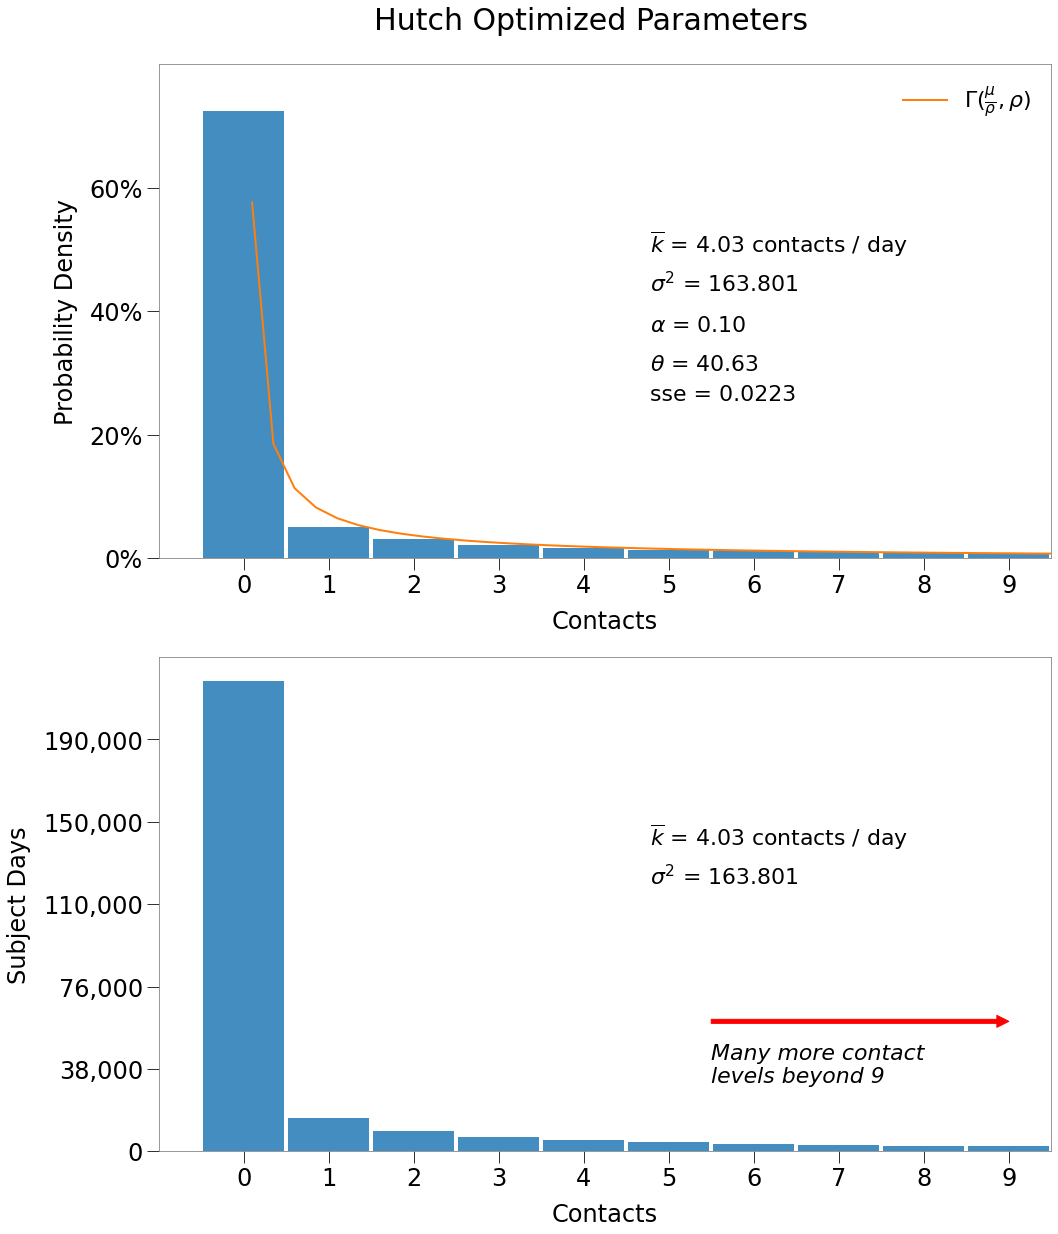

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,20))
with np.errstate(divide='ignore', invalid='ignore'):
    ktrhist(
        k_gam, overlay='gamma', fit=(mu, theta), 
        ax=ax1, xlim=10, return_hist=False
    )
    c_gam, c_bins  = ktrhist(
        k_gam, ax=ax2, xlim=10, return_hist=True, raw=True
    )
plt.annotate('', xy=(9.5, 60000), xytext=(6, 60000),
    arrowprops=dict(facecolor='red', edgecolor='red'),
)
plt.text(6, 50000, 'Many more contact \nlevels beyond 9', va='top', style='italic')
plt.suptitle('Hutch Optimized Parameters', y=.92)
plt.show()

By far, most dot-days must have 0 contacts. Above we zoomed in on the first 10 contact levels to give a sense for the most pertinent values.

Below we show the distribution tail. Remember that while the number of occurences is relatively low, given the contact level is so high they still produce a large number of contacts. 

For instance:

+ 2,000 dot-days of 2 contacts produces 4,000 contacts
+ 40 dot-days of 100 contacts produces 40,000 contacts

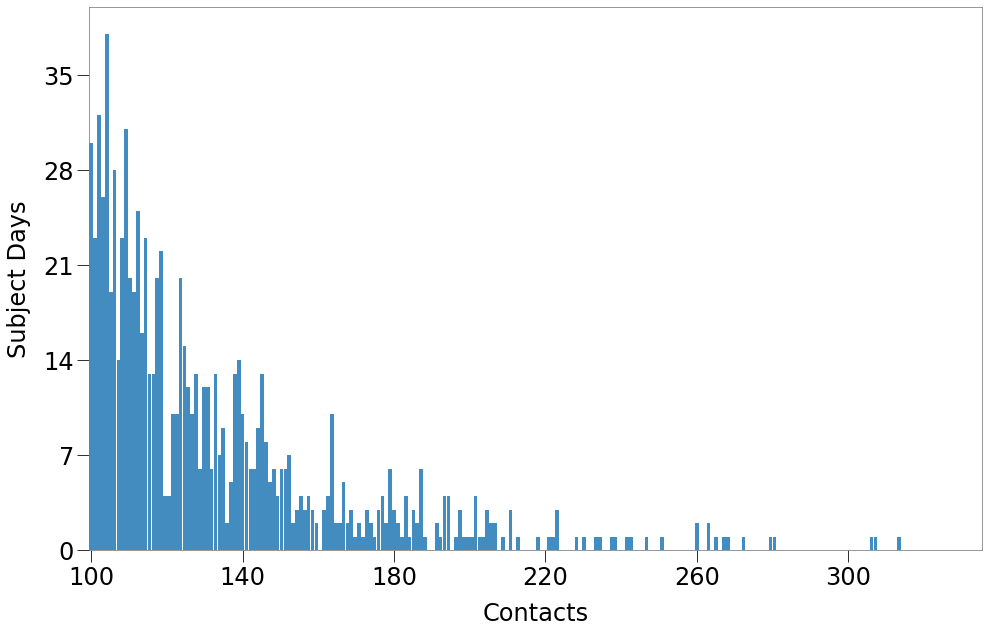

In [39]:
with np.errstate(divide='ignore', invalid='ignore'):
    k_gam = np.random.gamma(alpha, size=size, scale=theta)
    ktrhist(
        k_gam, figsize=(16,10),
        xlim=(100,330), ylim=(0,40), show_hist=False, raw=True, stats=False
    )
    plt.show()

From the distribution above, we can focus on the contacts that must be event-driven. For our sim, we have chosen contacts of 2 or more (equal to event apacity of 3) to result from events.

Thus, events must replicate the distribution below, which is still a gamma distribution, slightly modified from the original.

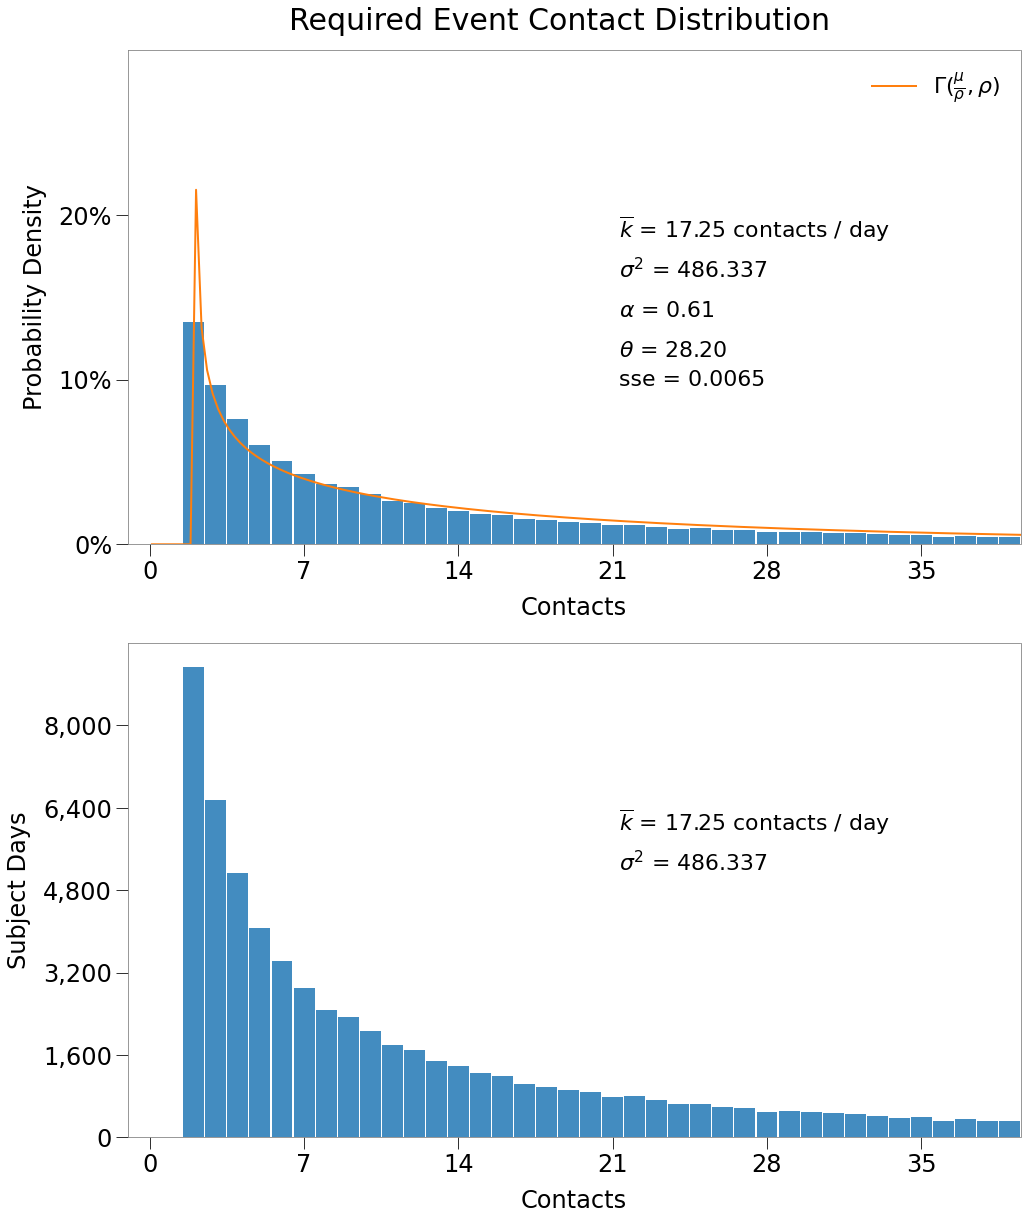

In [40]:
with np.errstate(divide='ignore', invalid='ignore'):
    mu_eve = k_gam[k_gam >= gloc].mean()
    theta_eve = k_gam[k_gam >= gloc].var() / k_gam[k_gam >= gloc].mean()

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,20))
    ktrhist(
        k_gam[k_gam >= gloc], ax=ax1, overlay='gamma', fit=(mu_eve, theta_eve, gloc),
        xlim=(0,40), ylim=(0, 0.3),
    )
    c_eve, b_eve = ktrhist(
        k_gam[k_gam >= gloc], ax=ax2, raw=True, xlim=40,
        return_hist=True
    )
    plt.suptitle('Required Event Contact Distribution', y=.91)

$\underline{\text{Creating Events}}$

The number of contacts for a single dot at an event is simply the capacity minus 1, since a dot cannot contact itself.

$$
\begin{equation}
k_e = \text{cap}_e - 1
\\\textit{where: } k_e \textit{ = contact level for event e}
\\\textit{cap}_e \textit{ = capacity for event e}
\end{equation}
$$

Multiplying again for every dot at the event gives us the total contacts for all dots:

$$
\begin{equation}
c_e\;=\;(cap_e - 1)*cap_e
\\\textit{where: } c_e \textit{ = total contacts for event e}
\end{equation}
$$

Remember that our target $\overline{k}$ is the average contact rate *per dot*, so the number of events should be structured on a per dot basis. The number of events required for a particular contact level, $k$, then, is:

$$
\begin{equation}
n_{e,j} = \frac{k_{tgt,i}}{cap_{e,j}}
\\\textit{i = contact level}
\\\textit{j = i + 1 = event capacity}
\end{equation}
$$

In [41]:
c_eve = c_eve.astype(np.int32)
caps = np.arange(c_eve.shape[0]) + 1

n_events = c_eve[gloc:] / caps[gloc:]

**RKnot's** ability to replicate the Gamma distribution fails on the long tail of the distribution when the number of occurences of a specified contact level is fewer than the contacts that would be generated by a single event.

For instance, the Hutch gamma distribution results in ~40 dot-days with 100 contacts. **RKnot** can only generate 100 contacts through a 100 contact event and a 100 contact event generates $(100-1)*100 = 9,900$ contacts, far more than required.

Our current hack-fix is to regroup and redistribute all contact occurences above that threshold into events. This results in a tail that is less evenly distributed.

A better solution would be to increase the number of ticks per day, which would allow for many more independent streams of contact distributions among dots. This feature will be available in future versions.

In [42]:
i_events = np.argwhere(n_events < 1 ).ravel()

i_large = i_events[0]

k_to_replicate = n_events[i_large:]*caps[gloc + i_large:]*caps[gloc + i_large:]

total = k_to_replicate.sum()
skip = 70
add_caps = []
for cap in range(i_large + skip + 1, i_large + k_to_replicate.shape[0] + 1, skip):
    total = total - ((cap - 1)*cap)
    if total < 0:
        break
    else:
        add_caps.append(cap)
        n_events[cap - 1] = 1
        
n_events = np.where(n_events >= 1, n_events, 0).astype(np.int32)

With the number of events for each capacity determined, we can assign event objects.

To do so, we:

+ utilize the ["baseus" groups used in the SIR analysis](sir.ipynb).
+ assign a p-value of .98 to the mover function of group.
    + *determined through a trial and error process that best fit the Hutch distribution.*
+ randomly assign each event a start tick between 1 and 30, which is the length of the simulation.
+ assign each event to `vbox=0`
+ as all events will occur inside a vbox, a `Travel` event must be used to transport them to the event location.

```python
from rknot.sims import baseus
from rknot.events import Travel

groups = baseus.groups
groups[2]['n_inf'] = 0
for group in groups:
    group['mover'] = .98

params = {'days': days, 'tmr_curve': sim_tmr, 'density': density, 'sterile': True}

event_groups = []
for i in np.arange(n_events.shape[0]):
    if n_events[i] >= 1:
        event_group = {'name': f'{i+gloc+1}n', 'n': n_events[i], 'groups': [0,1,2,3], 'capacity': i+gloc+1}
        event_groups.append(event_group)

events = []
for i, e in enumerate(event_groups):
    for j in range(e['n']):
        start_tick = np.random.randint(1, 31, 1, dtype=np.int32)
        events.append(
            Travel(name='{}_{}'.format(e['name'], j), start_tick=start_tick[0], groups=e['groups'], capacity=e['capacity'], vbox=0)
        )
```

In [43]:
if True:
    from rknot.sims import baseus
    from rknot.helpers import pickload
    
    eventfile = 'rknot/events/structures'
    structures = pickload(eventfile)

    events = structures['US Base w Load']['2020-12-07']['events']
    vbox = structures['US Base w Load']['2020-12-07']['vbox']
        
    groups = baseus.groups
    groups[2]['n_inf'] = 0
    for group in groups:
        group['mover'] = .98
        
    params = {}
    params['days'] = days
    params['tmr_curve'] = sim_tmr
    params['density'] = density
    params['sterile'] = True
        
else:
    from rknot.sims import baseus
    from rknot.events import Travel
    
    groups = baseus.groups
    groups[2]['n_inf'] = 0
    for group in groups:
        group['mover'] = .98

    params = {}
    params['days'] = days
    params['tmr_curve'] = sim_tmr
    params['density'] = density
    params['sterile'] = True

    event_groups = []
    for i in np.arange(n_events.shape[0]):
        if n_events[i] >= 1:
            event_group = {   
                'name': f'{i+gloc+1}n',
                'n': n_events[i],
                'groups': [0,1,2,3],
                'capacity': i+gloc+1,
            }
            event_groups.append(event_group)

    events = []
    for i, e in enumerate(event_groups):
        for j in range(e['n']):
            start_tick = np.random.randint(1, 31, 1, dtype=np.int32)
            events.append(
                Travel(
                    name='{}_{}'.format(e['name'], j), start_tick=start_tick[0],
                    groups=e['groups'], 
                    capacity=e['capacity'], vbox=0,
                )
            )

In the chart below, we can see the distribution of the capacity of the events generated by this process over the life of the simulation.

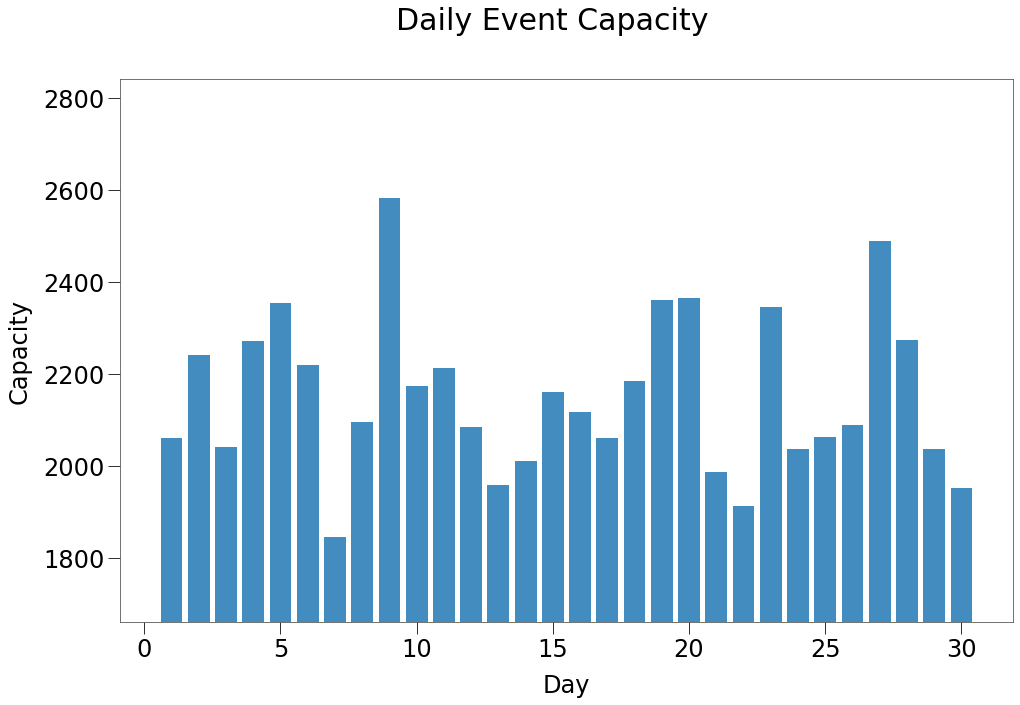

In [44]:
start_ticks = np.array([e.start_tick for e in events])
caps = np.array([e.capacity for e in events])

c = {}
for start_tick, cap in zip(start_ticks, caps):
    if start_tick in c:
        c[start_tick] += cap
    else:
        c[start_tick] = cap

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.bar(c.keys(), c.values())
ax.set_xlabel('Day')
ax.set_ylabel('Capacity')
ax.set_ylim(min(c.values())*0.9, max(c.values())*1.1)
plt.suptitle('Daily Event Capacity')
plt.show()

So, for the length of the simulation between 18 to 26% of the population will be attending events *each day of the simulation*.

Below, we can see that for the lower contact levels, this approach generates a near perfect replica of the required Gamma distribution.

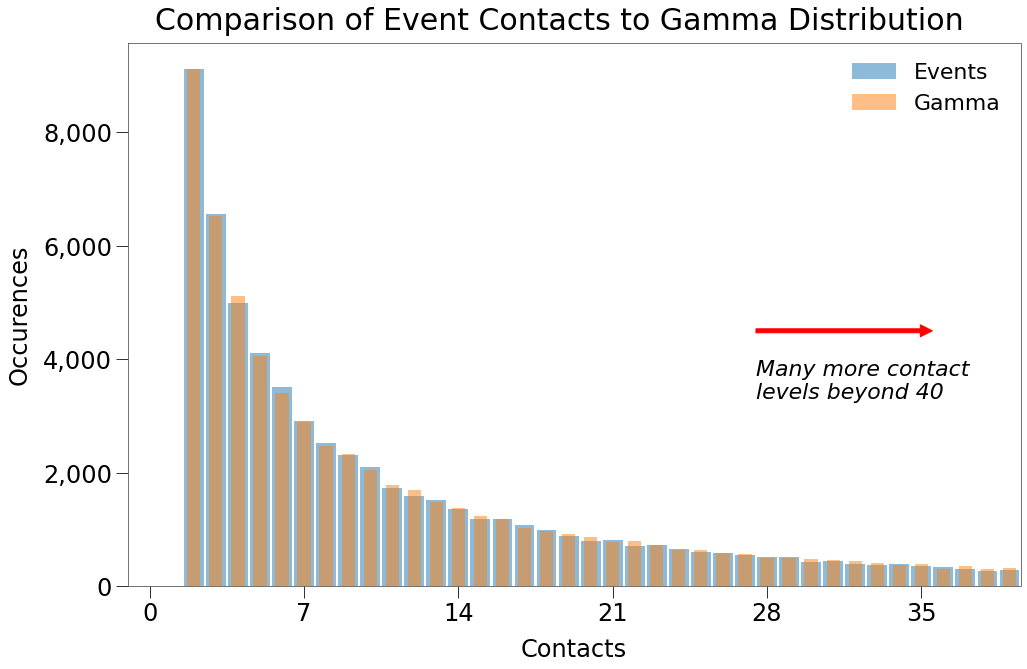

In [45]:
from rknot.notebook import ktrbar
with np.errstate(divide='ignore', invalid='ignore'):
    counts, bins = np.histogram(caps-1, bins=np.arange(max(caps) + 1))
    contacts = counts*(np.arange(counts.shape[0])+1)
    title = 'Comparison of Event Contacts to Gamma Distribution'

    ktrbar(contacts, c_eve, xlim=40, title=title, title_y=.93)
    plt.annotate('', xy=(36, 4500), xytext=(28, 4500),
        arrowprops=dict(facecolor='red', edgecolor='red'),
    )
    plt.text(28, 4000, 'Many more contact \nlevels beyond 40', va='top', style='italic')
    plt.show()

When we focus on contact levels of 100+, however, you can see that we only generate contacts at 3 levels.

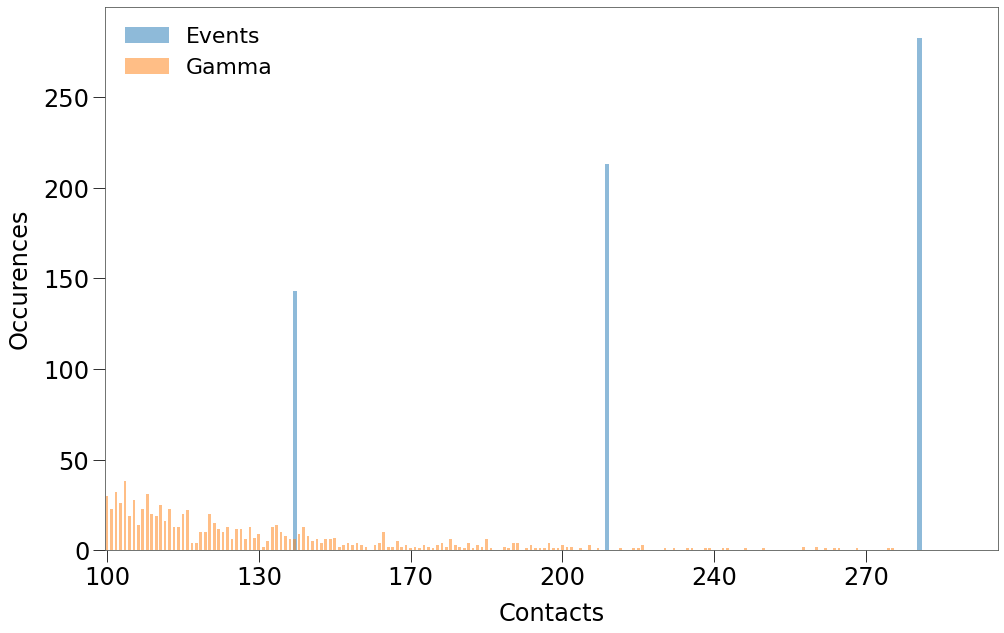

In [46]:
with np.errstate(divide='ignore', invalid='ignore'):
    ktrbar(contacts, c_eve, xlim=(100,300), ylim=300)
plt.show()

$\underline{\text{Forming the Remaining Environment}}$

With contact levels 2+ settled, we must set the non-event environment such that it generates mainly 0 contacts.

First, we find the average density of the grid (excluding the vbox) during the sim. Only dots not attending events will be in the main grid, so density is as follows:

In [49]:
n_dots_at_events = np.array(list(c.values())).mean()
n_dots_not_events = n - n_dots_at_events

d = n_dots_not_events / n # given density of 1

print (np.around(d, 2))

0.78


In [77]:
text = f'The density of the grid excluding dots on events will be {d:.2f}.'
text += 'So we can find the expected $\overline{k}$ of that space using the '
text += '[polyfit equation we found above](#Movement-Changes) to find the ' 
text += 'corresponding variance and providing the `p-value` for group movement. '
text += 'And then apply $\overline{k}$ to a normal distribution to find the '
text += 'expected contacts for the non-event space.'
md(text)

The density of the grid excluding dots on events will be 0.78.So we can find the expected $\overline{k}$ of that space using the [polyfit equation we found above](#Movement-Changes) to find the corresponding variance and providing the `p-value` for group movement. And then apply $\overline{k}$ to a normal distribution to find the expected contacts for the non-event space.

In [51]:
import shelve
from datetime import datetime as dt, timedelta as td
file = 'tests/data/sizing_ktr_polyfit'
date = '2020-12-12'
with shelve.open(file, writeback=True) as db:
    z = db[date]

In [52]:
f = np.poly1d(d*z)
mu_space = f(.98)
var_space = mu_space

x = np.linspace(0, 5, int(n_dots_not_events*30))
counts = st.norm.pdf(x, mu_space, var_space)

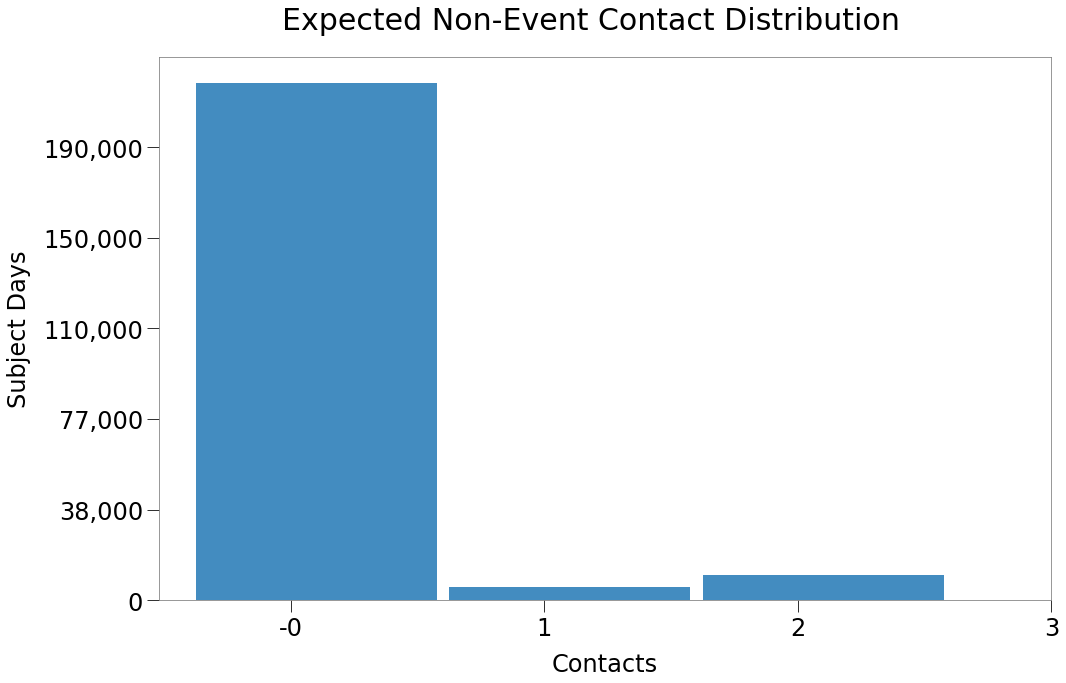

In [78]:
with np.errstate(divide='ignore', invalid='ignore'):
    ktrhist(counts, raw=True, stats=False, 
        title='Expected Non-Event Contact Distribution', title_y=.95
    )

Thus, we expect the non-event space will result in 200,000+ dot days with no contacts, right in line with Hutch gamma.

The final step in preparing the simulation environment is determing the size of the VBox. The chart below shows the number of events occuring on each tick in the Sim.

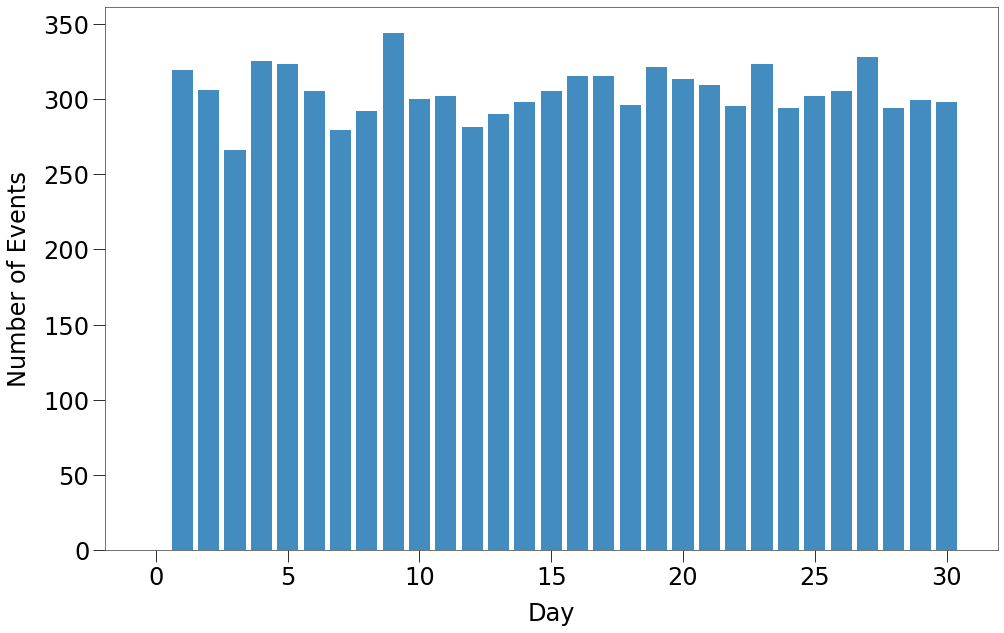

In [54]:
n_events_by_tick = np.bincount(start_ticks)

fig, ax = plt.subplots(1,1,figsize=(16,10))
plt.bar(np.arange(n_events_by_tick.shape[0]), n_events_by_tick)
plt.xlabel('Day')
plt.ylabel('Number of Events')
plt.show()

Above we can see that there are typically ~300 events occuring on a given tick.

The vbox must allow for each event to have its own location, so the vbox should have enough locations to support the maximum number of events occuring on the same tick, which is:

In [55]:
start_ticks = np.array([e.start_tick for e in events])
n_events_by_tick = np.bincount(start_ticks)
n_events_by_tick.max()

344

In [56]:
text = f'The vbox must have {n_events_by_tick.max()} locations.'
md(text)

The vbox must have 344 locations.

$\underline{\text{Run the Sim}}$

We will run a single Sim to use for `all_contacts` comparison:

```python
vbox = n_events_by_tick.max()
sim = Sim(groups=groups, events=events, vboxes=vbox, **params)
sim.run(dotlog=True)

all_contacts = find_all_contacts(sim.dotlog, MLNB)
eR0_all = np.sum(all_contacts[:,:sim_tmr.shape[0]]*sim_tmr, axis=1).mean()
```

We can see from the outputs that the sim produces fairly similar outcomes to those desired.

In [57]:
from rknot.helpers import ShelfHelp

if False:
    vbox = structures['US Base w Load']['2020-12-07']['vbox']
    sim = Sim(groups=groups, events=events, vboxes=vbox, **params)
    sim.run(dotlog=True)

    all_contacts = find_all_contacts(sim.dotlog, MLNB)

from datetime import datetime as dt, timedelta as td
file = 'tests/data/sizing_complex'
key = 'complex_1.8'

try:
    args = [sim, all_contacts]
except NameError:
    args = []
    
with ShelfHelp(file, key) as sh:
    dotlog, all_contacts, tmrs = sh.values(*args)
    
eR0_all = np.sum(all_contacts[:,:tmrs.shape[0]]*tmrs, axis=1).mean()

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



$\underline{\text{Results}}$

The sim reproduced $R_0$ as desired, however, contact rate is slightly below target and theta slightly over. This is likely the result of the long-tail issues described earlier.

In [65]:
table = r'''
    <table>
        <thead>
            <tr>
                <th class="results-table">$R_0$</th>
                <th class="results-table">$\overline{{k}}$</th>
                <th class="results-table">$\theta$</th>
            </tr>
        </thead>
    '''
table += f'''
        <tbody>
            <tr>
                <td class="results-table">{eR0_all:.2f}</td>
                <td class="results-table">{all_contacts.mean():.2f}</td>
                <td class="results-table">{all_contacts.var()/all_contacts.mean():.2f}</td>
            </tr>
        </tbody>
    </table>
'''

display(HTML((table)))

$R_0$,$\overline{{k}}$,$\theta$
1.82,3.36,54.56


And the contact distribution visually fits the desired Gamma almost perfectly.

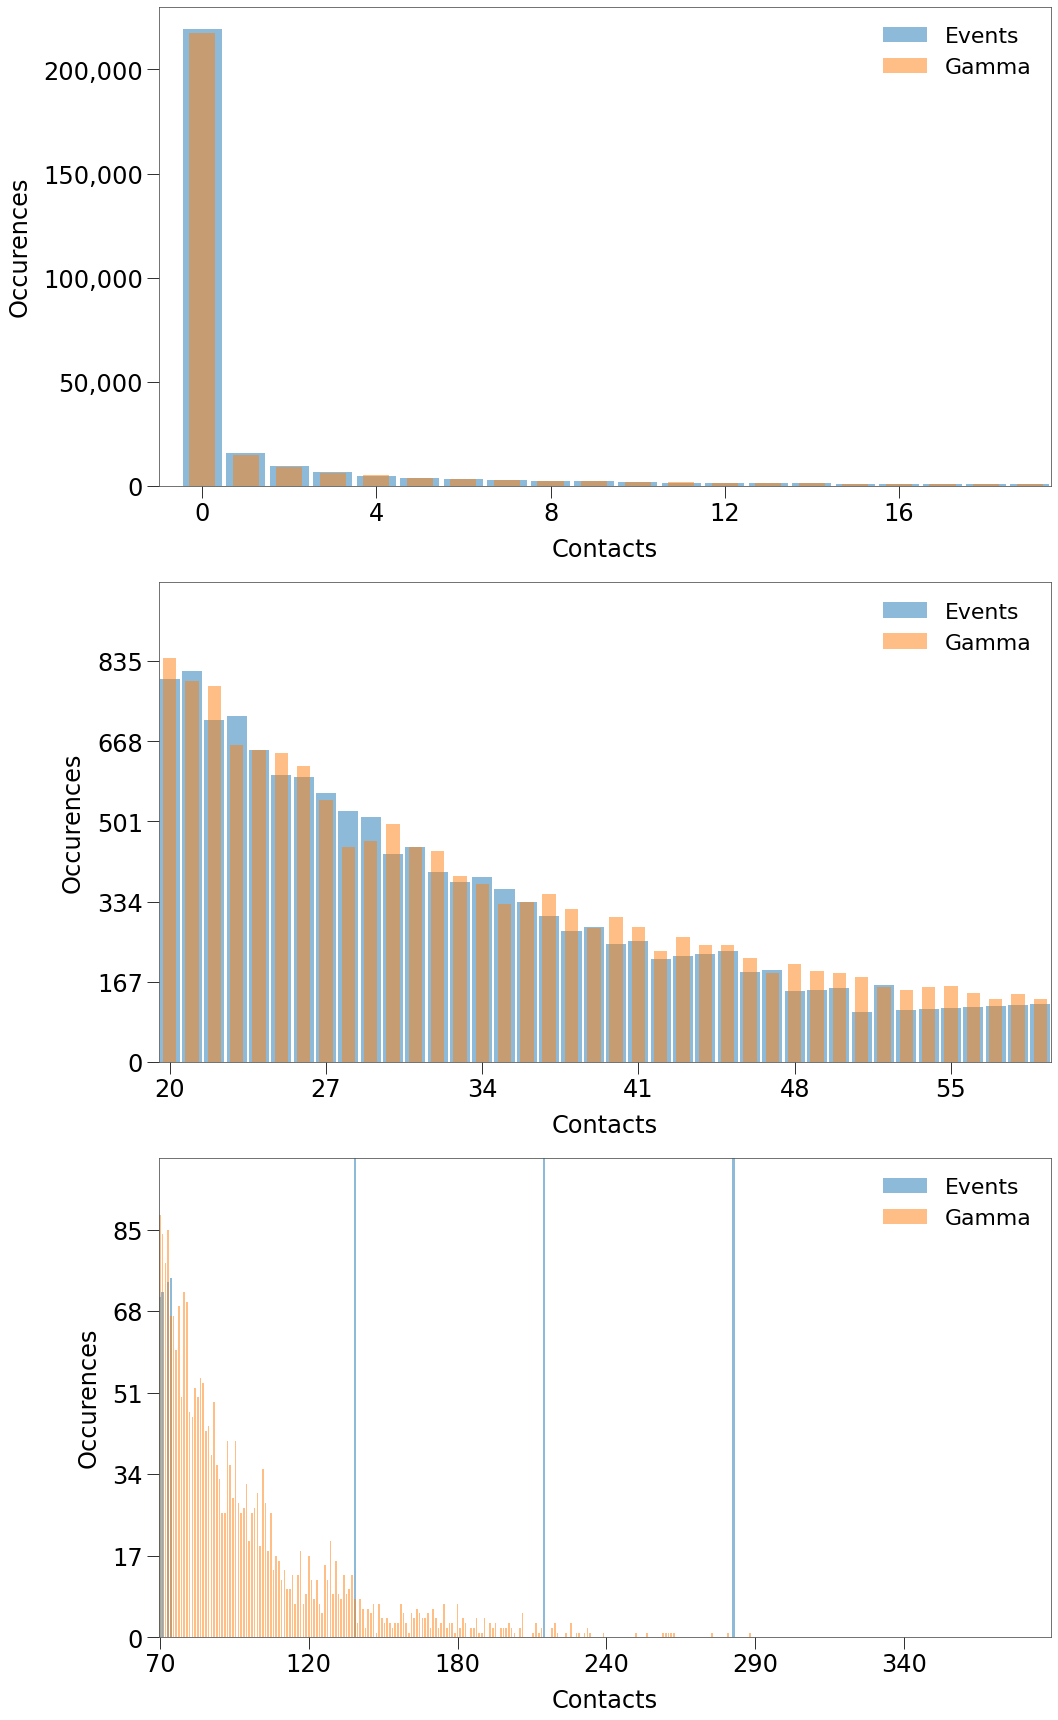

In [59]:
import numpy as np
import matplotlib.pyplot as plt

from rknot.notebook import ktrbar

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16, 30))
contacts, bins = np.histogram(all_contacts, bins=np.arange(all_contacts.max() + 2))

with np.errstate(divide='ignore', invalid='ignore'):
    ktrbar(contacts, c_gam, ax=ax1, xlim=20)
    ktrbar(contacts, c_gam, ax=ax2, xlim=(20, 60), ylim=1000)
    ktrbar(contacts, c_gam, ax=ax3, xlim=(70, 400), ylim=100)

plt.show()

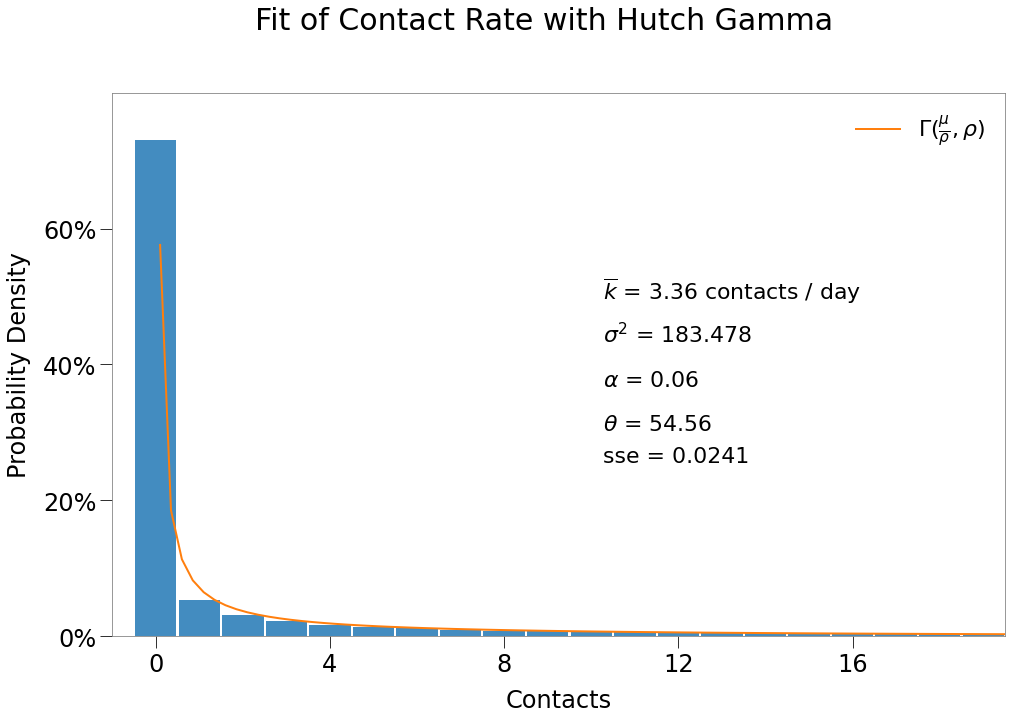

In [60]:
with np.errstate(divide='ignore', invalid='ignore'):
    title = 'Fit of Contact Rate with Hutch Gamma'
    ktrhist(all_contacts, overlay='gamma', fit=(mu, theta), xlim=20, title=title)
plt.show()

And that the expected $R_0$ distribtion is a much stronger fit for the Endo model (although still underweight slightly to 0 infection outcomes).

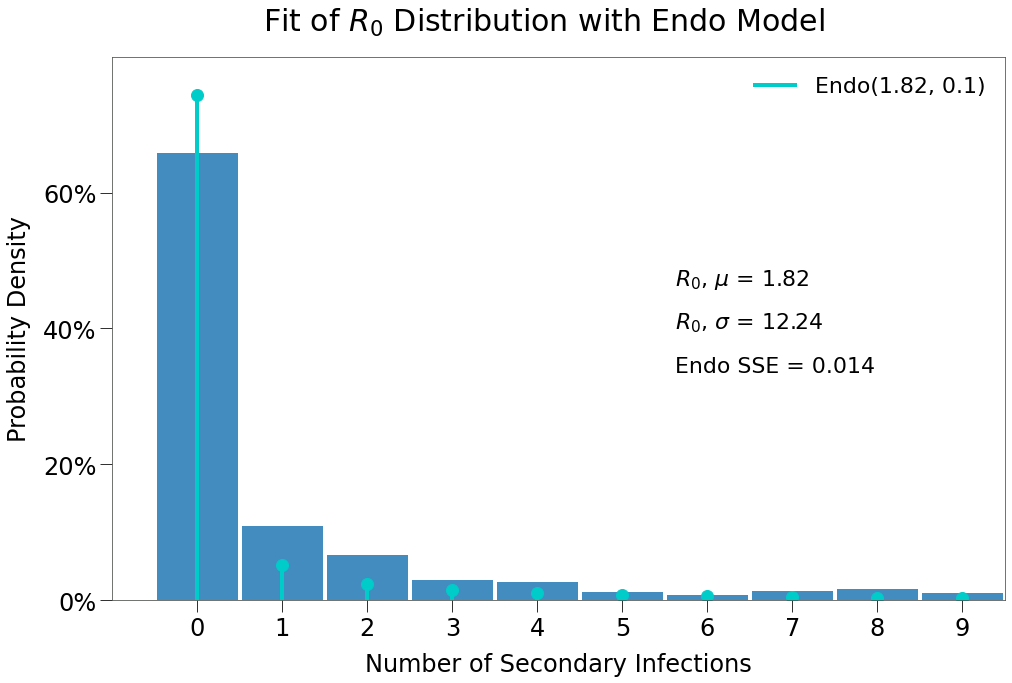

In [61]:
with np.errstate(divide='ignore', invalid='ignore'):
    title = r'Fit of $R_0$ Distribution with Endo Model'
    rohist(all_contacts*sim_tmr, R0=tgt_R0, compare=['endo'], xlim=10, title=title, title_y=.95)

$\underline{\text{Run a Larger Dataset}}$

The `all_contacts` method is good way to get a quick read on the viability of an environment, however, it is still only a rough estimate. Truly reliable statistics can only come from running the simulation many times.

We will loop through 1,000 sims:

```python
n = 1000
contacts, nsecs, results, exceptions = looper(groups, n, params['density'], params['days'], tmr=sim_tmr, events=events, vboxes=vbox)
```

In [62]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from rknot.sims import us_w_load_testing
from rknot.helpers import ShelfHelp, looper, pickload
from rknot.notebook import md, modulereload
from rknot.dots.fhutch import tmr

modulereload(us_w_load_testing)

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters'
simbase = us_w_load_testing.__name__.split('.')[-1]

SAVE = False
if SAVE:
    n = 500
    days = 30
    density = 1
    
    eventfile = 'rknot/events/structures'
    structures = pickload(eventfile)

    events = structures['US Base w Load']['2020-12-07']['events']
    vbox = structures['US Base w Load']['2020-12-07']['vbox']

    sim_tmr = tmr

    contacts, nsecs, results, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  tmr=sim_tmr, events=events, vboxes=vbox,
    )

from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, sim_tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []

with ShelfHelp(file, key) as sh:
    n, sim_tmr, contacts, nsecs, results = sh.values(*args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



$\underline{\text{Results}}$

In [63]:
eR0 = np.mean(contacts.reshape(-1,sim_tmr.shape[0])*sim_tmr, axis=0).sum()
R0 = nsecs.sum(axis=1).mean()

In [67]:
table = r'''
    <table>
        <thead>
            <tr>
                <th class="results-table">E($R_0$)</th>
                <th class="results-table">$R_0$</th>
                <th class="results-table">$\overline{{k}}$</th>
                <th class="results-table">$\theta$</th>
            </tr>
        </thead>
    '''
table += f'''
        <tbody>
            <tr>
                <td class="results-table">{eR0:.2f}</td>            
                <td class="results-table">{R0:.2f}</td>
                <td class="results-table">{contacts.mean():.2f}</td>
                <td class="results-table">{contacts.var()/contacts.mean():.2f}</td>
            </tr>
        </tbody>
    </table>
'''

display(HTML((table)))

E($R_0$),$R_0$,$\overline{{k}}$,$\theta$
1.78,1.72,3.34,59.72


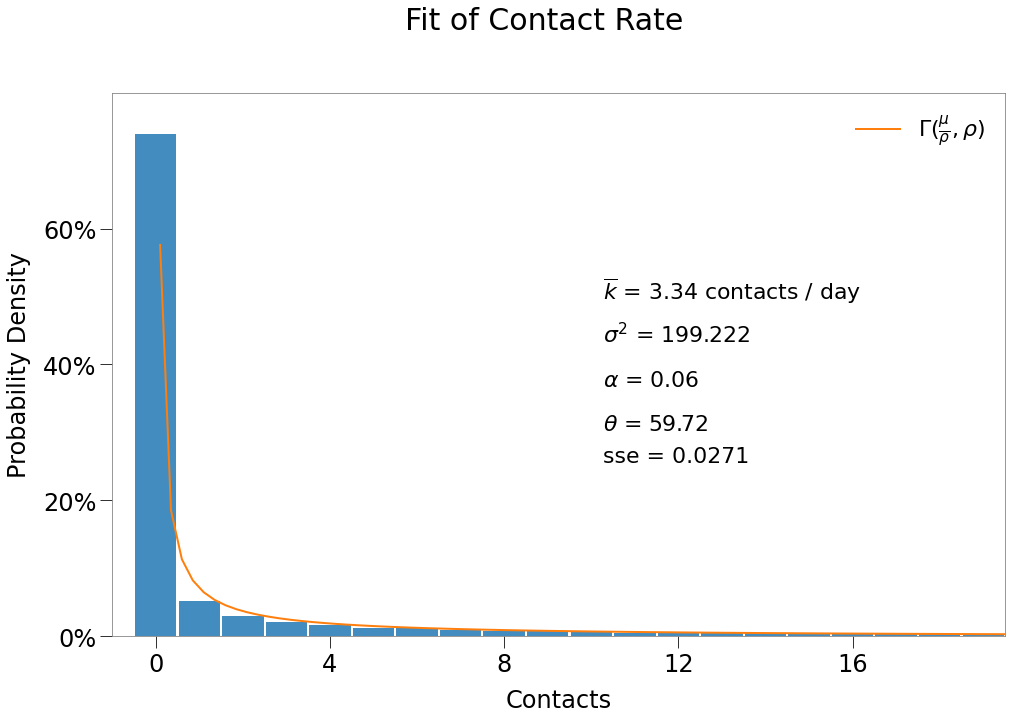

In [68]:
from rknot.notebook import ktrhist
with np.errstate(divide='ignore', invalid='ignore'):
    ktrhist(contacts, 
            figsize=(16,10), title='Fit of Contact Rate', 
            overlay='gamma', fit=(mu, theta), xlim=20)
plt.show()

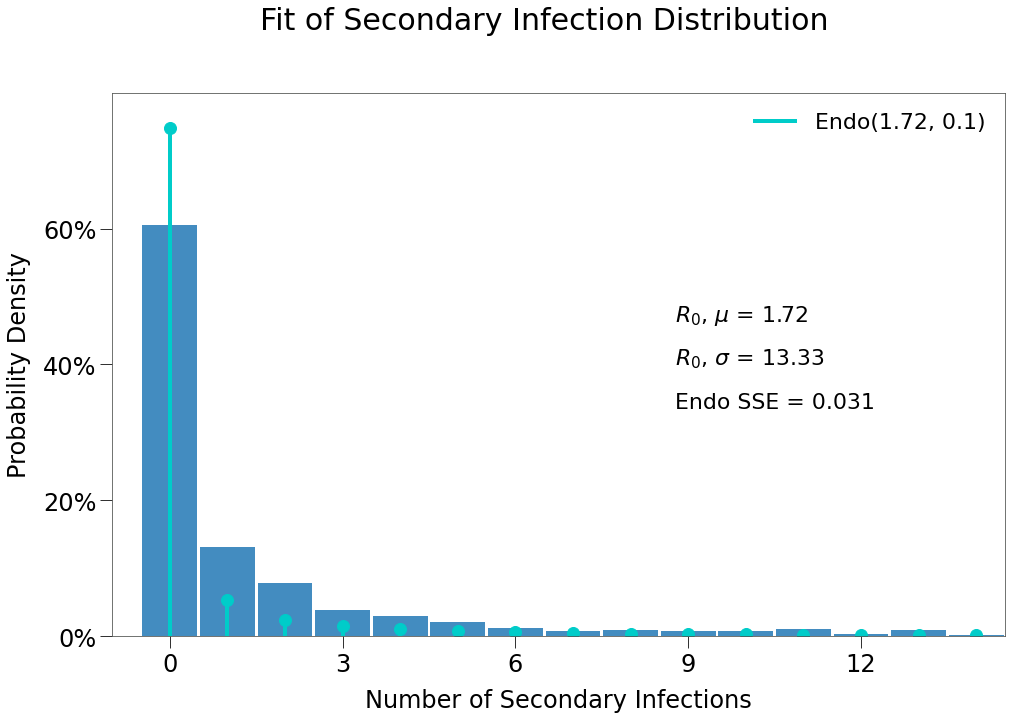

In [69]:
with np.errstate(divide='ignore', invalid='ignore'):
    rohist(nsecs, title='Fit of Secondary Infection Distribution', R0=tgt_R0, 
           compare=['endo'], density=density, xlim=(0,15)
    )

The above iterations set `sterile=True`, in order to isolate the contacts and secondary infections of *just the initial infected*.

We can learn more about the outcomes in the simulation by again using `looper` and setting `sterile=False`, `days=365`. We will complete just 250 iterations, because each sim will run longer.

```python
n = 250
days = 365
contacts, nsecs, results, exceptions = looper(groups, n, density, days, tmr=sim_tmr, events=events, vboxes=vbox, sterile=False)
```

In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np

from rknot.sims import us_w_load_testing
from rknot.helpers import ShelfHelp, looper, pickload
from rknot.notebook import md, modulereload
from rknot.dots.fhutch import tmr

modulereload(us_w_load_testing)

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS'
simbase = us_w_load_testing.__name__.split('.')[-1]

SAVE = False
if SAVE:
    n = 248
    days = 365
    density = 1
    eventfile = 'rknot/events/structures'
    structures = pickload(eventfile)

    events = structures['US Base w Load']['2020-12-07']['events']
    for event in events:
        event.recurring = 30

    vbox = structures['US Base w Load']['2020-12-07']['vbox']

    sim_tmr = tmr

    contacts, nsecs, results, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  
        tmr=sim_tmr, events=events, vboxes=vbox, sterile=False,
    )

tgt_R0 = 1.8
mu = 4
theta = 40

from rknot.helpers import ShelfHelp
try:
    args = n, contacts, nsecs, results, sim_tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res1 = sh.values(*args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np

from rknot.sims import us_w_load_testing
from rknot.helpers import ShelfHelp, looper, pickload
from rknot.notebook import md
from rknot.dots.fhutch import tmr

modulereload(us_w_load_testing)

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'
simbase = us_w_load_testing.__name__.split('.')[-1]

SAVE = False
if SAVE:
    n = 250
    days = 365
    density = 1
    eventfile = 'rknot/events/structures'
    structures = pickload(eventfile)

    events = structures['US Base w Load']['2020-12-07']['events']
    for event in events:
        event.recurring = 30

    vbox = structures['US Base w Load']['2020-12-07']['vbox']

    sim_tmr = tmr
    
    us_w_load_testing.groups[2]['n_inf'] = 1
    contacts, nsecs, results, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  
        tmr=sim_tmr, events=events, vboxes=vbox, sterile=False,
    )

try:
    args = n, contacts, nsecs, results, sim_tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c2, nsecs2, res2 = sh.values(*args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [82]:
from rknot.notebook import curve_table

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

res2 = np.around(res2, 3)
res2 = res2[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

persec = np.array([(np.sum(res2[:,1] == 0) / res2.shape[0])])

means2 = np.concatenate((res2.mean(axis=0), persec))
means2_gt_0 = np.zeros(5)
for i in range(res2.shape[1]):
    exc = res2[:,i][np.argwhere(res2[:,i] >= 0.1).ravel()].mean()
    means2_gt_0[i] = exc

headers = ['1 Infection', '2 Infections', '1 Infection<br>$R_0$ > 0', '2 Infections<br>$R_0$ > 0'] 
args = [means1, means2, means1_gt_0, means2_gt_0]
    
display(HTML((curve_table(headers, args, style='results-nofat'))))

,1 Infection,2 Infections,1 Infection$R_0$ > 0,2 Infections$R_0$ > 0
Peak,3.8%,8.9%,34.5%,33.1%
HIT,4.6%,11.1%,42.3%,41.1%
Total,5.9%,14.0%,53.8%,52.3%
Days to Peak,11,24,28,38


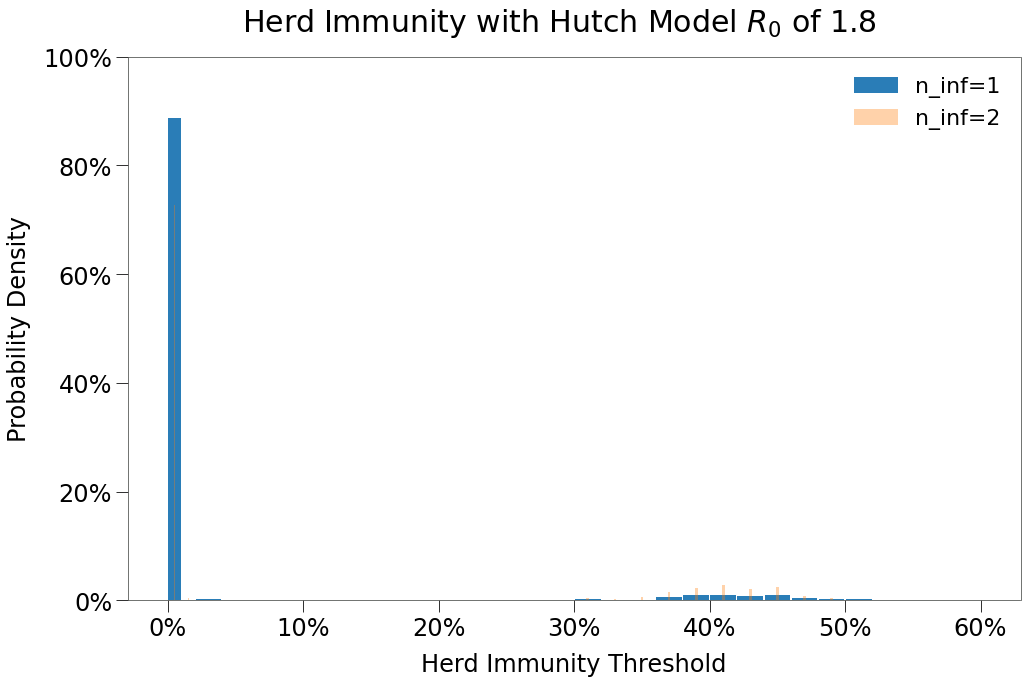

In [73]:
from rknot.notebook import curvehist
labels = [r'n_inf=1', r'n_inf=2']
title = r'Herd Immunity with Hutch Model $R_0$ of 1.8'
curvehist([res1[:,1], res2[:,1]], labels, title=title)

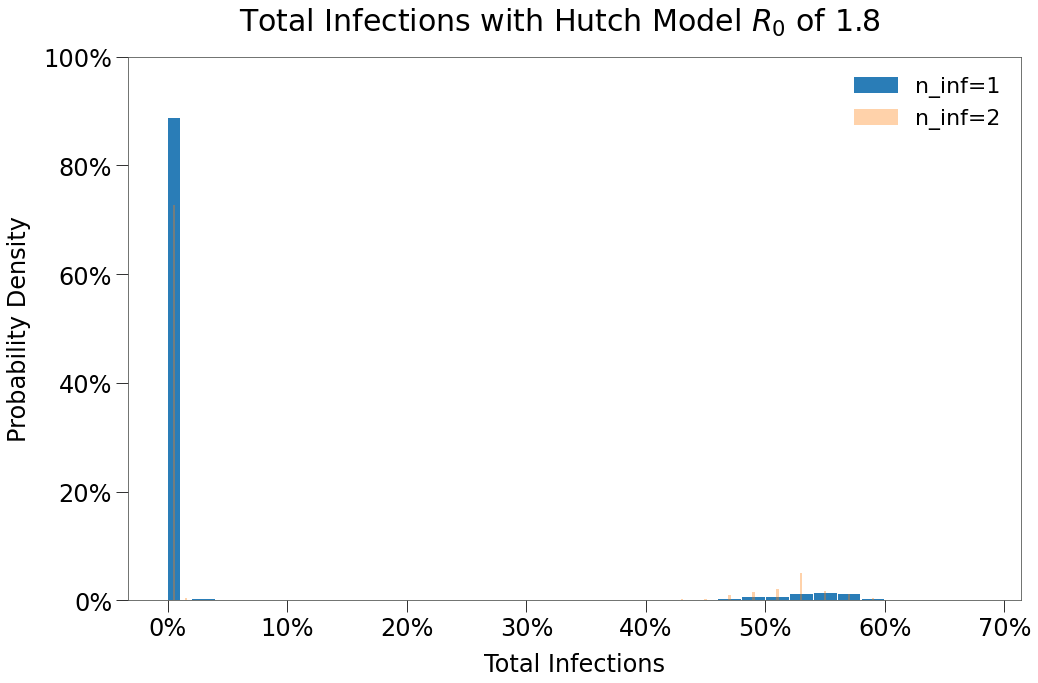

In [74]:
from rknot.notebook import curvehist
labels = [r'n_inf=1', r'n_inf=2']
title = r'Total Infections with Hutch Model $R_0$ of 1.8'
curvehist([res1[:,2], res2[:,2]], labels, title=title, which='tot')

!!!!!!!!!!!BELOW HERE IS HIDDEN!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Hutch Model: $R_0$ of 2.5 (non-optimal) ####

We can use the process defined [above](#R0-of-1.8) to define event structures for any desired initial conditions, including the more commonly cited $R_0$ of 2.5 (for sars-cov-2).

$\mu$ and $\theta$ are not known and so must be determined iteratively. We have shown the best fit below according to our own trial and error assessment.

Our initial conditions are the exact same as the previous environment, except for the contact Gamma parameters.

In [62]:
%load_ext autoreload
%autoreload 2

import shelve
import math
import numpy as np
import scipy.stats as st
from datetime import datetime as dt, timedelta as td

import matplotlib.pyplot as plt

from IPython.core.display import HTML

from rknot import Sim, Chart
from rknot.events import Event, Travel
from rknot.sims import us_w_load_testing
from rknot.helpers import looper, contacts_of_init_inf, pickload, picksave
from rknot.notebook import modulereload, md, ktrhist, rohist, ktrbar, check_capacity
from rknot.dots.matrix import MLNB, ML
from rknot.nb import funcs as nbf
from rknot.dots.fhutch import tmr, tmr75
from rknot.dots import Group, GroupArray as Groups
from rknot.space import Box

modulereload(us_w_load_testing)

plt.style.use('rknot_nb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
n = 10000
days = 30
size = n*days
density = 1
gloc = 2
sim_tmr = tmr

mu = 7
theta = 50
tgt_R0 = 2.5

```python
from rknot.notebook import calc_c_gam, calc_c_eve, find_n_events, setup_travels, check_capacity
from rknot.sims import baseus

with np.errstate(divide='ignore', invalid='ignore'):
    k_gam, c_gam = calc_c_gam(mu, theta, size)
    c_eve = calc_c_eve(k_gam, gloc)

n_events = find_n_events(c_eve, gloc)
params, events = setup_travels(baseus.groups, sim_tmr, density, days, n_events, gloc, p_val=.98)

c, start_ticks = check_capacity(events)

n_dots_at_events = np.array(list(c.values())).mean()
n_dots_not_events = n - n_dots_at_events

d = n_dots_not_events / n # given density of 1

n_events_by_tick = np.bincount(start_ticks)
vbox = n_events_by_tick.max()
sim = Sim(groups=baseus.groups, events=events, vboxes=vbox, **params)
sim.run(dotlog=True)
all_contacts = nbf.find_all_contacts(sim.dotlog, MLNB)
```

In [64]:
eventfile = 'rknot/events/structures'
structures = pickload(eventfile)

events = structures['US Base w Load']['2020-12-08']['events']
vbox = structures['US Base w Load']['2020-12-08']['vbox']
params = {'density': density, 'days': days, 'sterile': True, 'tmr_curve': sim_tmr}

SAVE = False
if SAVE:
    sim = Sim(groups=us_w_load_testing.groups, events=events, vboxes=vbox, **params)
    sim.run(dotlog=True)
    all_contacts = nbf.find_all_contacts(sim.dotlog, MLNB)

from rknot.helpers import ShelfHelp
file = 'tests/data/sizing_complex'
key = 'complex_2.5'

try:
    args = [sim, all_contacts]
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    dotlog, all_contacts, tmrs = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [65]:
eR0_all = np.sum(all_contacts[:,:sim_tmr.shape[0]]*sim_tmr, axis=1).mean()
vals = eR0_all, all_contacts.mean(), all_contacts.var() / all_contacts.mean()

table = r'| E($R_0$)  |  $\mu$   |  $\sigma^2$  |'
table += ' \n'
table += '|:-------------:| :-------------: |:-------------:|'
table += ' \n |  {:.2f}   |   {:.2f}    |   {:.2f} |'.format(*vals)

md(table)

| E($R_0$)  |  $\mu$   |  $\sigma^2$  | 
|:-------------:| :-------------: |:-------------:| 
 |  2.47   |   5.92    |   74.27 |

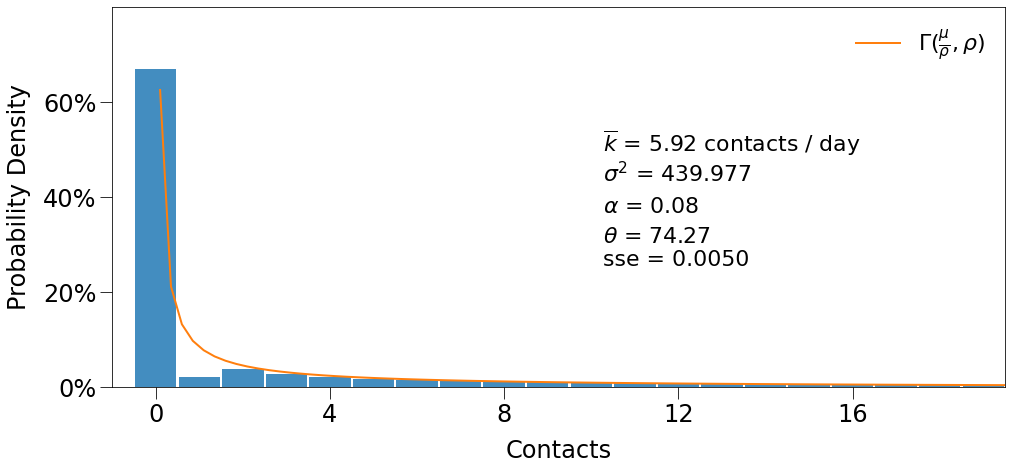

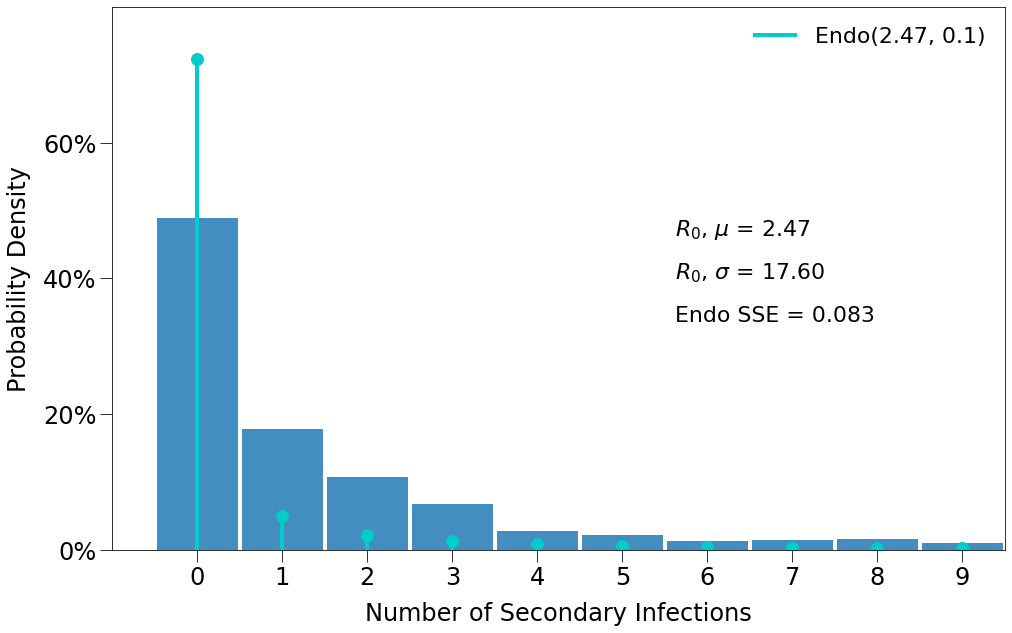

In [66]:
from rknot.notebook import ktrhist
with np.errstate(divide='ignore', invalid='ignore'):
    ktrhist(all_contacts, overlay='gamma', fit=(mu, theta), xlim=20, ylim=(0, .8))
    rohist(all_contacts*sim_tmr, R0=tgt_R0, density=density, xlim=10)
plt.show()

In [67]:
from rknot.helpers import ShelfHelp
file = 'tests/data/sizing_complex'
key = 'complex_2.5_iters'

if False:
    n = 1000
    contacts, nsecs, _, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  tmr=sim_tmr, events=events, vboxes=vbox, 
    )

with ShelfHelp(file, key) as sh:
    n, infdur, contacts, nsecs, res = sh.values()
    sim_tmr = np.array([1/infdur])*infdur

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [68]:
eR0 = np.mean(contacts.reshape(-1,sim_tmr.shape[0])*sim_tmr, axis=0).sum()
R0 = nsecs.sum(axis=1).mean()

In [69]:
args = eR0, R0, contacts.mean(), contacts.var() / contacts.mean()

table = r'Sim Results'
table = r'| E($R_0$)| Act. $R_0$  |  $\mu$   |  $\theta$  |'
table += ' \n'
table += '|:-------------:|:-------------:| :-------------: |:-------------:|'
table += ' \n | {:.2f} |  {:.2f}   |   {:.2f}    |   {:.2f} |'.format(*args)
md(table)

| E($R_0$)| Act. $R_0$  |  $\mu$   |  $\theta$  | 
|:-------------:|:-------------:| :-------------: |:-------------:| 
 | 5.94 |  2.58   |   5.94    |   82.43 |

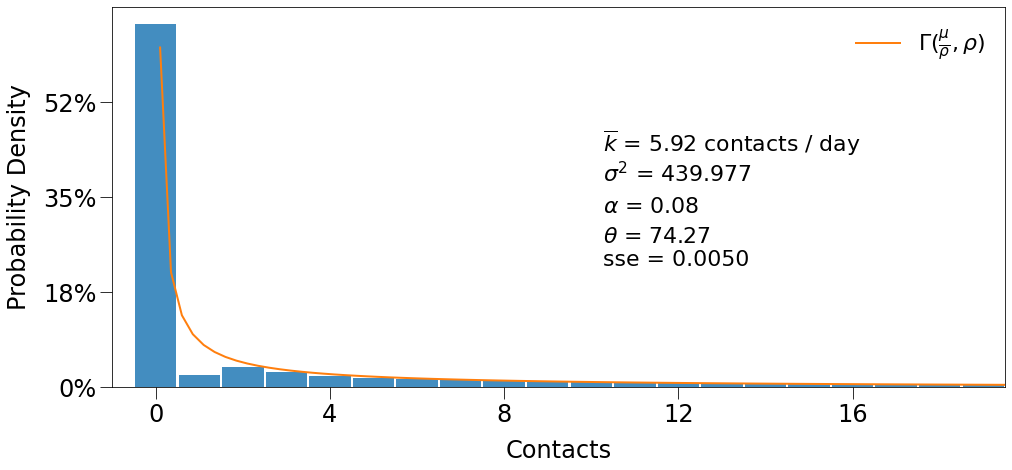

In [70]:
with np.errstate(divide='ignore', invalid='ignore'):
    ktrhist(all_contacts, overlay='gamma', fit=(mu, theta), xlim=20)
plt.show()

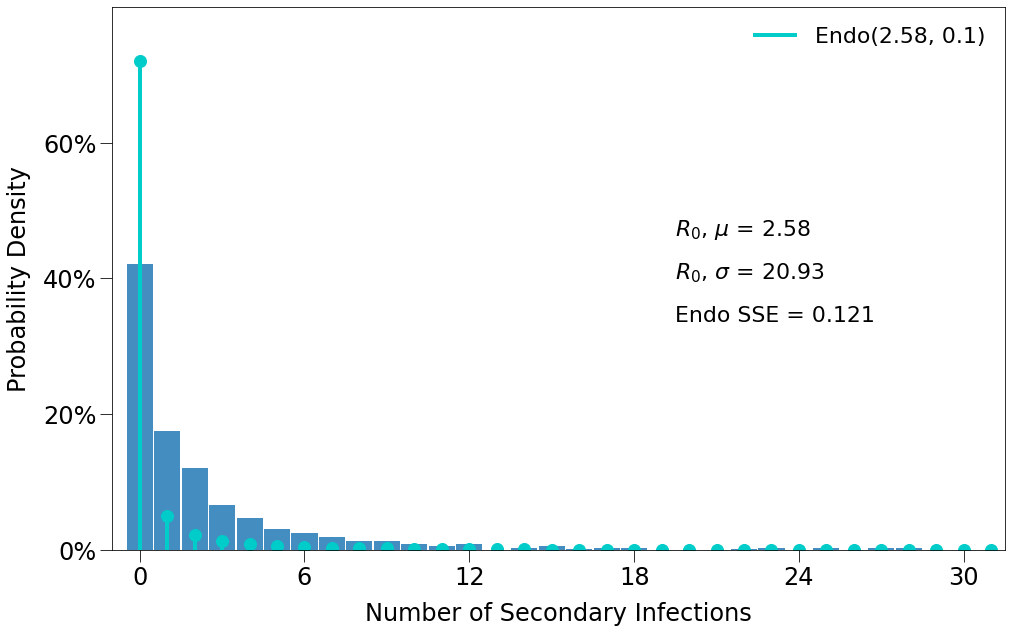

In [71]:
with np.errstate(divide='ignore', invalid='ignore'):
    rohist(nsecs, R0=tgt_R0, compare=['endo'], density=density)

In [88]:
modulereload(us_w_load_testing)

days = 365
density = 1
sim_tmr = tmr


eventfile = 'rknot/events/structures'
structures = pickload(eventfile)
events = structures['US Base w Load']['2020-12-08']['events']
vbox = structures['US Base w Load']['2020-12-08']['vbox']
for event in events:
    event.recurring = 30

SAVE = False
if SAVE:
    n = 250
    contacts, nsecs, results, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  
        tmr=sim_tmr, events=events, vboxes=vbox, sterile=False,
    )

from rknot.helpers import ShelfHelp
file = 'tests/data/sizing_complex'
key = 'complex_2.5_iters_RESULTS'
simbase = us_w_load_testing.__name__.split('.')[-1]

try:
    args = n, contacts, nsecs, results, sim_tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [86]:
SAVE = False

if SAVE:
    us_w_load_testing.groups[0]['n_inf'] = 1
    us_w_load_testing.groups[1]['n_inf'] = 2
    us_w_load_testing.groups[2]['n_inf'] = 2
    n = 250
    contacts, nsecs, results, exceptions = looper(
        us_w_load_testing.groups, n, density, days,  
        tmr=sim_tmr, events=events, vboxes=vbox, sterile=False,
    )

from rknot.helpers import ShelfHelp
file = 'tests/data/sizing_complex'
key = 'complex_2.5_iters_RESULTS_n_inf_5'
simbase = us_w_load_testing.__name__.split('.')[-1]

try:
    args = n, contacts, nsecs, results, sim_tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c2, nsecs2, res2 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [93]:
from rknot.notebook import curve_table

res1 = np.around(res1, 3)
persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])

means1 = np.concatenate((res1.mean(axis=0), persec))
means1 = means1[[0,1,2,-2,-1]]
    
res2 = np.around(res2, 3)
persec = np.array([(np.sum(res2[:,1] == 0) / res2.shape[0])])

means2 = np.concatenate((res2.mean(axis=0), persec))
means2 = means2[[0,1,2,-2,-1]]

headers = ['n_inf = 1', 'n_inf = 5'] 
args = [t for tup in zip(means1, means2) for t in tup]
    
md(curve_table(res2.shape[0], headers, args))

Average Values

|      | n_inf = 1   | n_inf = 5   | 
| ------------- |:-------------:|:-------------:| 
| Peak      |   27.6% |   72.9% | 
| HIT      | 28.4%     |   74.8% | 
| Total      | 29.4%      |   77.4% | 
| Days to Peak      | 20.3      |   45.4 | 
| No Secondary |  61.6% |    1.2% |

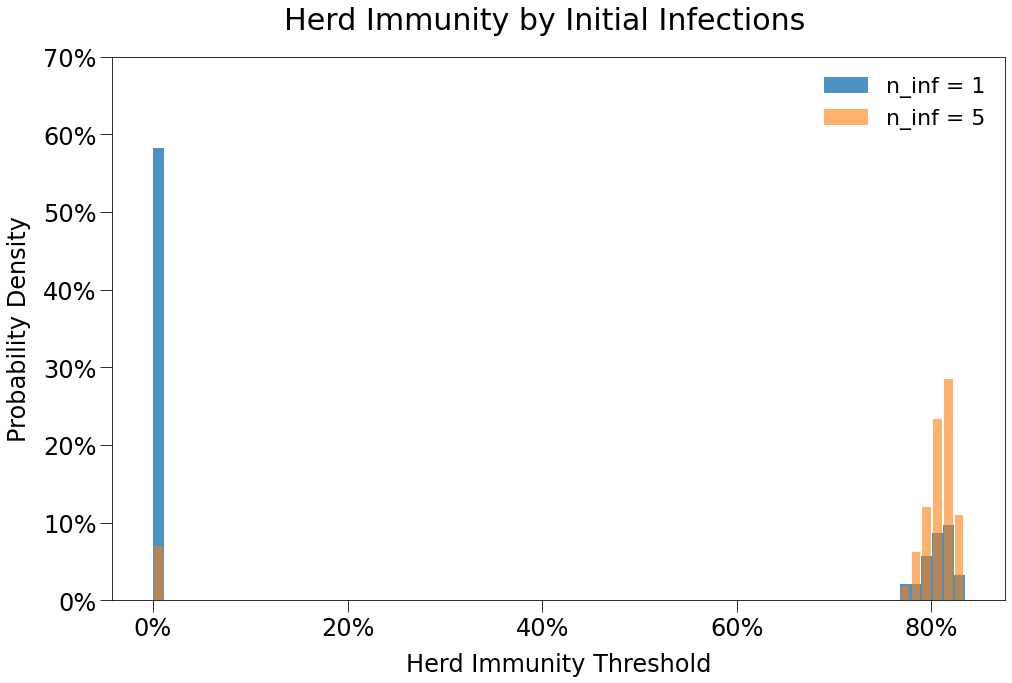

In [96]:
from rknot.notebook import curvehist
labels = ['n_inf = 1', 'n_inf = 5']
title = 'Herd Immunity by Initial Infections'
curvehist([res1[:,1], res2[:,1]], labels, title=title)

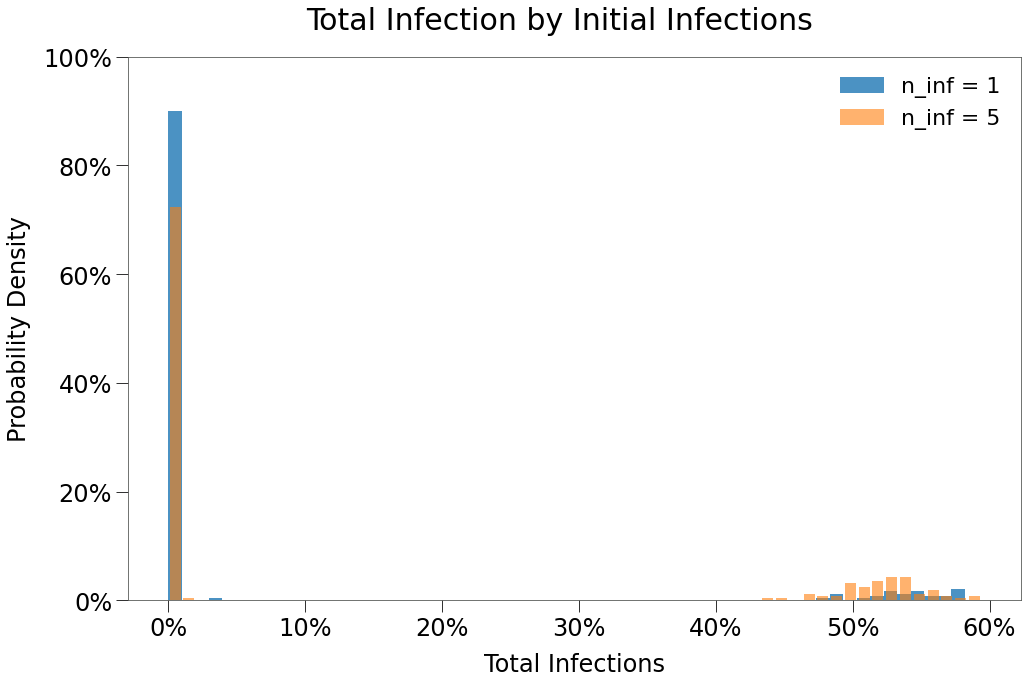

In [21]:
labels = ['n_inf = 1', 'n_inf = 5']
title = 'Total Infection by Initial Infections'
curvehist([res1[:,2], res2[:,2]], labels, title=title, which='tot')

In [ ]:
%%javascript
 IPython.notebook.save_notebook()

In [17]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('sizing.ipynb')